# Rolling Planning mit Lateness (Tardiness + Earliness)

In [2]:
max_time = 60*60*1 # 1h

In [3]:
import time

from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 20)

import utils.presenter as show
import utils.checker as check

import utils.scheduling_solver as ssv
import utils.rescheduling_solver_lateness as rssv

import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced
import utils.schedule_deadline as deadline_gen

from ProductionDaySimulation import ProductionDaySimulation

In [4]:
start_notebook = time.time()

In [5]:
def get_schedule_filename(prefix: str = "", day: int = 0, data_txt: str = "schedule", suffix: str = "") -> str:
    file_template = "data/{prefix}_{data}_{day:02d}{suffix}.csv"
    if suffix:
        suffix = f"_{suffix}"
    return file_template.format(prefix=prefix,data=data_txt,day=day, suffix=suffix)

## Generierung des Datensatzes für 15 Tage (Ankunft)

In [7]:
days_numb = 15

In [8]:
df_instance = pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, days_numb,  u_b_mmax = 0.98)
df_jssp

Job Operation Machine Processing Time
0     Job_000         0      M0              29
1     Job_000         1      M1              78
2     Job_000         2      M2               9
3     Job_000         3      M3              36
4     Job_000         4      M4              49
...       ...       ...     ...             ...
2845  Job_284         5      M9              76
2846  Job_284         6      M5              47
2847  Job_284         7      M3              52
2848  Job_284         8      M4              90
2849  Job_284         9      M7              45

[2850 rows x 4 columns]

In [9]:
# Deadlines + Umwandlung in Integer
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1)
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int)
df_times

Job  Arrival  Deadline
0    Job_000        0      1244
1    Job_001       80      1687
2    Job_002      140      1929
3    Job_003      191      2254
4    Job_004      226      1465
..       ...      ...       ...
280  Job_280    21253     23317
281  Job_281    21259     22498
282  Job_282    21260     23050
283  Job_283    21376     22620
284  Job_284    21472     23174

[285 rows x 3 columns]

## Params

In [11]:
# fix
day_length = 1440

In [12]:
# init
day_numb = 0

day_start = 0
day_end = 0

# Initialisierung (Tag 0)

In [14]:
day_numb = 0

day_start = day_length*day_numb      # 0
day_end = day_start + day_length     # 1440

In [15]:
# I)
df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, day_end)
df_jssp_curr

Job Operation Machine Processing Time
0    Job_000         0      M0              29
1    Job_000         1      M1              78
2    Job_000         2      M2               9
3    Job_000         3      M3              36
4    Job_000         4      M4              49
..       ...       ...     ...             ...
185  Job_018         5      M9              76
186  Job_018         6      M5              47
187  Job_018         7      M3              52
188  Job_018         8      M4              90
189  Job_018         9      M7              45

[190 rows x 4 columns]

In [16]:
df_times_curr 

Job  Arrival  Deadline
0   Job_000        0      1244
1   Job_001       80      1687
2   Job_002      140      1929
3   Job_003      191      2254
4   Job_004      226      1465
5   Job_005      293      1856
6   Job_006      330      1641
7   Job_007      473      2171
8   Job_008      687      2567
9   Job_009      718      2419
10  Job_010      819      2517
11  Job_011      867      2748
12  Job_012      921      2528
13  Job_013     1088      2651
14  Job_014     1093      3157
15  Job_015     1099      2338
16  Job_016     1100      2890
17  Job_017     1216      2460
18  Job_018     1312      3014

### Scheduling

In [18]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_cp_jssp_lateness_by_tardiness_and_earliness(df_jssp_curr, df_times_curr,
                                                                w_t = 5,
                                                                msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Objective Value       : 35.00
Best Objective Bound  : 35.00
Laufzeit              : 0.61 Sekunden

Scheduling-Dauer: 0 Minuten und 0.75 Sekunden.


Job  Operation  Arrival  Deadline Machine  Start  Processing Time  \
0    Job_000          0        0      1244      M0      0               29   
1    Job_000          1        0      1244      M1     29               78   
2    Job_001          0       80      1687      M0     80               43   
3    Job_000          2        0      1244      M2    107                9   
4    Job_000          3        0      1244      M3    116               36   
..       ...        ...      ...       ...     ...    ...              ...   
185  Job_013          9     1088      2651      M7   2626               25   
186  Job_011          9      867      2748      M8   2674               74   
187  Job_016          9     1100      2890      M4   2857               33   
188  Job_018          9     1312      3014      M7   2969               45   
189  Job_014          9     1093      3157      M5   3114               43   

      End  Lateness  Tardiness  Earliness  
0      29     -1215          0       1215  
1     107     -1137          0       1137  
2     123     -1564          0       1564  
3     116     -1128          0       1128  
4     152     -1092          0       1092  
..    ...       ...        ...        ...  
185  2651         0          0          0  
186  2748         0          0          0  
187  2890         0          0          0  
188  3014         0          0          0  
189  3157         0          0          0  

[190 rows x 11 columns]

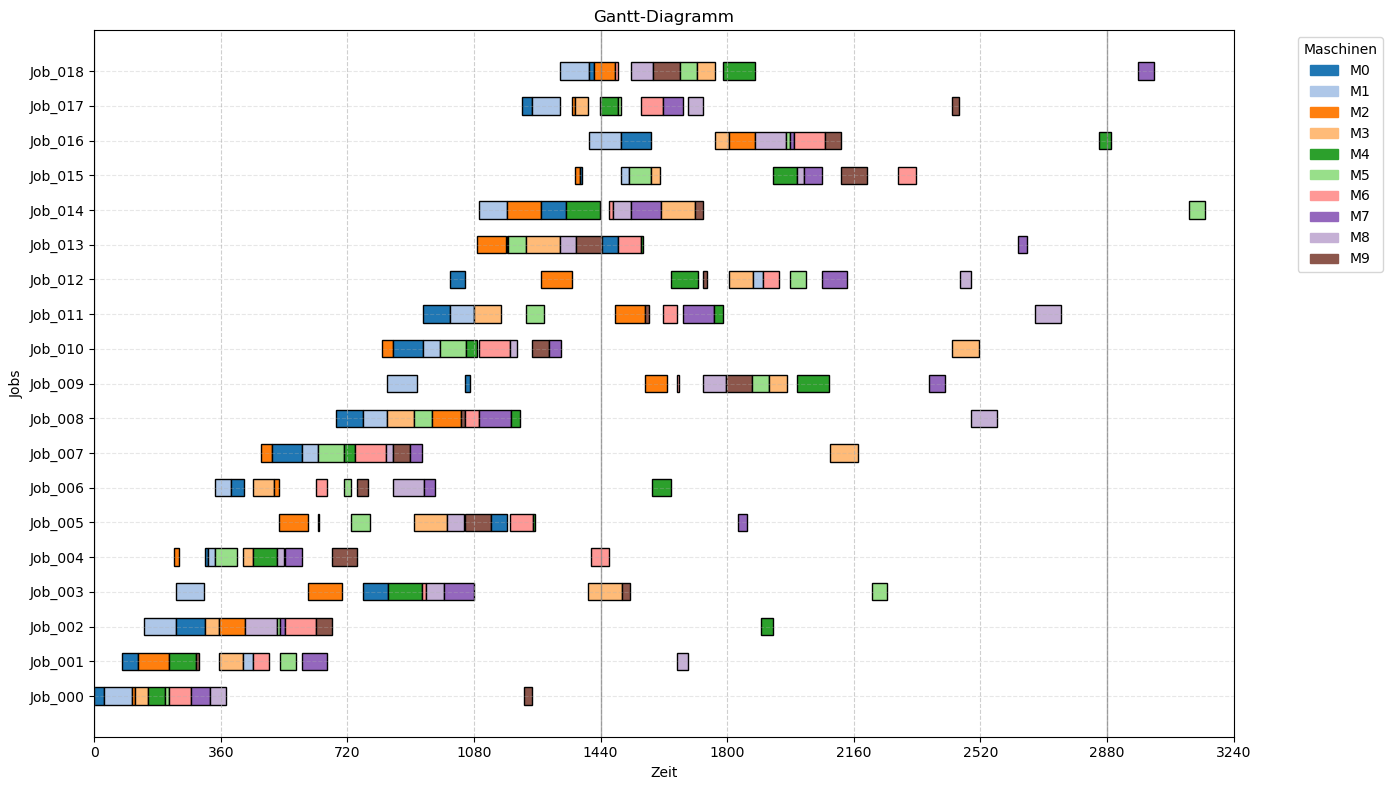

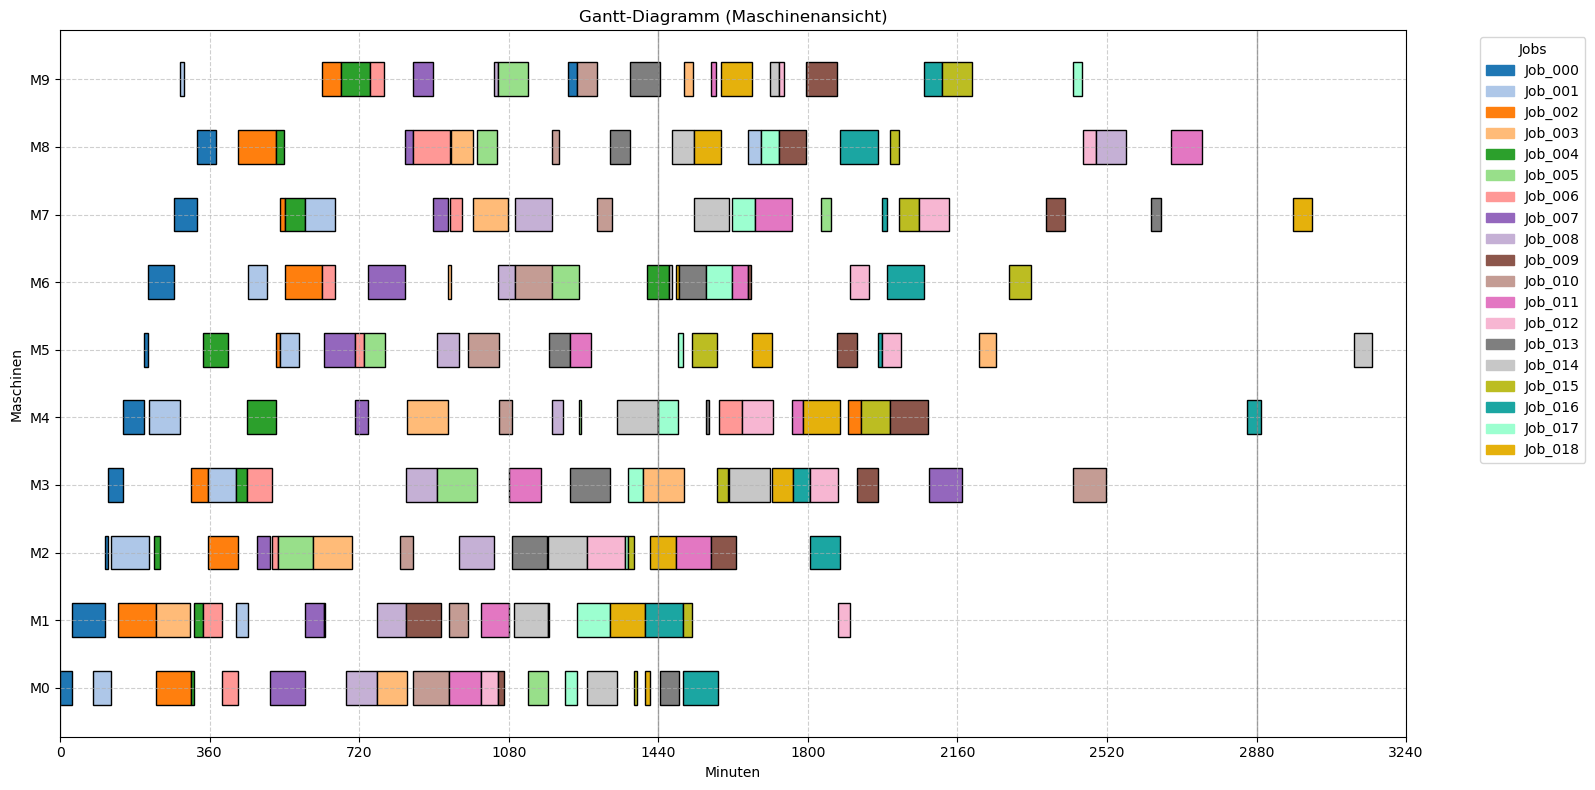

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [19]:
show.plot_gantt_jobs(df_plan)
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [20]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 90, steps= 30)

label
<-90          0
-90 - -60     0
-60 - -30     1
-30 - 0       0
0            18
0 - 30        0
30 - 60       0
60 - 90       0
>90           0
Name: count, dtype: int32

### Simulation

In [22]:
filt = (df_plan.Start < day_end)
df_plan_for_sim = df_plan[filt]
df_plan_for_sim

Job  Operation  Arrival  Deadline Machine  Start  Processing Time  \
0    Job_000          0        0      1244      M0      0               29   
1    Job_000          1        0      1244      M1     29               78   
2    Job_001          0       80      1687      M0     80               43   
3    Job_000          2        0      1244      M2    107                9   
4    Job_000          3        0      1244      M3    116               36   
..       ...        ...      ...       ...     ...    ...              ...   
115  Job_016          0     1100      2890      M1   1408               91   
116  Job_018          1     1312      3014      M0   1408               13   
117  Job_004          9      226      1465      M6   1412               53   
118  Job_018          2     1312      3014      M2   1421               61   
119  Job_017          4     1216      2460      M4   1439               49   

      End  Lateness  Tardiness  Earliness  
0      29     -1215          0       1215  
1     107     -1137          0       1137  
2     123     -1564          0       1564  
3     116     -1128          0       1128  
4     152     -1092          0       1092  
..    ...       ...        ...        ...  
115  1499     -1391          0       1391  
116  1421     -1593          0       1593  
117  1465         0          0          0  
118  1482     -1532          0       1532  
119  1488      -972          0        972  

[120 rows x 11 columns]

In [23]:
simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[01:20:00] Job_001 started on M0
[01:55:19] Job_001 finished on M0 (after 35 minutes 20 seconds)
[02:03:00] Job_001 started on M2
[02:16:13] Job_000 finished on M1 (after 107 minutes 13 seconds)
[02:20:00] Job_002 started on M1
[03:57:14] Job_002 finished on M1 (after 97 minutes 14 seconds)
[03:57:14] Job_003 started on M1
[03:57:14] Job_002 started on M0
[04:16:52] Job_001 finished on M2 (after 133 minutes 52 seconds)
[04:16:52] Job_000 started on M2
[04:16:52] Job_001 started on M4
[04:24:41] Job_000 finished on M2 (after 07 minutes 49 seconds)
[04:24:41] Job_004 started on M2
[04:24:41] Job_000 started on M3
[04:43:51] Job_004 finished on M2 (after 19 minutes 10 seconds)
[04:52:25] Job_000 finished on M3 (after 27 minutes 44 seconds)
[05:18:54] Job_001 finished on M4 (after 62 minutes 02 seconds)
[05:18:54] Job_000 started on M4
[05:18:54] Job_001 started

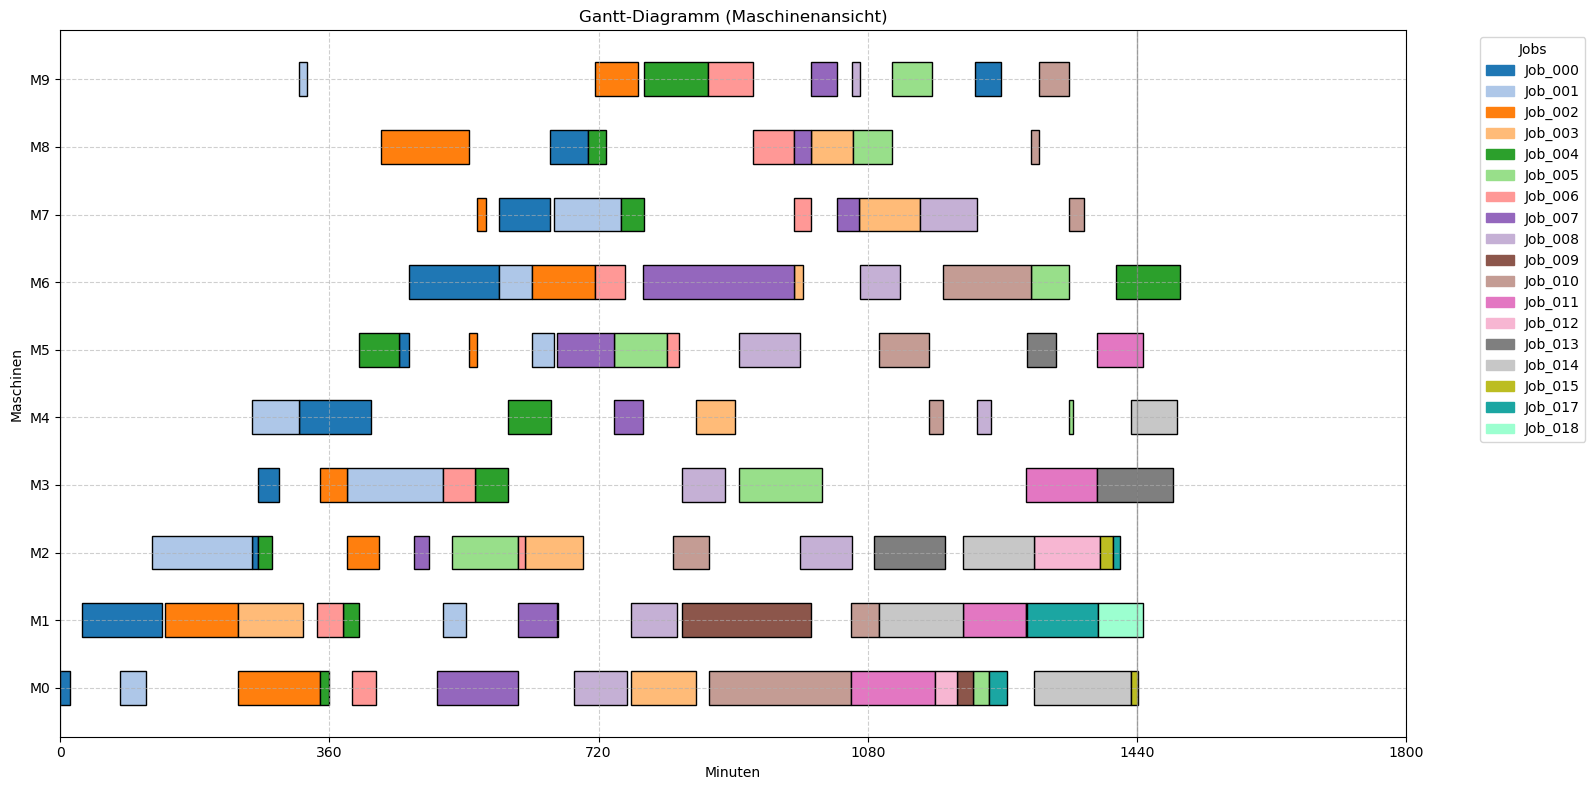

In [24]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [25]:
df_undone.sort_values(by="Arrival")

Job  Operation  Arrival Machine  Planned Start  Processing Time
3  Job_003          7      191      M3           1404               98
0  Job_013          4     1088      M8           1323               48
2  Job_013          5     1088      M9           1371               72
4  Job_016          0     1100      M1           1408               91
1  Job_017          3     1216      M3           1368               36
7  Job_017          4     1216      M4           1439               49
5  Job_018          1     1312      M0           1408               13
6  Job_018          2     1312      M2           1421               61

In [26]:
df_plan.to_csv(get_schedule_filename("06", day=day_numb, suffix="init"), index = False)

In [27]:
df_plan_init = df_plan
df_execution_init = df_execution
df_undone_init = df_undone

## A) Rolling Planning Simple

**Zielfunktion:**

Minimiere die gewichtete Summe aus Tardiness und Earliness der Jobs:

\\[
Z(\sigma) = \sum_{j} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right)
\\]

wobei:

- \\( w_t \in \mathbb{N},\ w_e \in \mathbb{N} \\): Gewicht für Tardiness und Earliness  
- \\( \text{Tardiness}_j = \max(0, C_j - d_j) \\), \\( \text{Earliness}_j = \max(0, d_j - C_j) \\)  
    - \\( C_j \\): Fertigstellungszeitpunkt der letzten Operation von Job \\( j \\)  
    - \\( d_j \\): Deadline für Job \\( j \\)

In [30]:
day_start = 1440

In [31]:
df_plan_prev = df_plan_init

filt = (df_plan_prev.Start >= day_start)
df_plan_prev_important = df_plan_prev[filt]
df_plan_prev_important

Job  Operation  Arrival  Deadline Machine  Start  Processing Time  \
120  Job_013          6     1088      2651      M0   1443               47   
121  Job_014          4     1093      3157      M6   1465                9   
122  Job_014          5     1093      3157      M8   1474               52   
123  Job_011          4      867      2748      M2   1482               85   
124  Job_018          3     1312      3014      M6   1482                7   
..       ...        ...      ...       ...     ...    ...              ...   
185  Job_013          9     1088      2651      M7   2626               25   
186  Job_011          9      867      2748      M8   2674               74   
187  Job_016          9     1100      2890      M4   2857               33   
188  Job_018          9     1312      3014      M7   2969               45   
189  Job_014          9     1093      3157      M5   3114               43   

      End  Lateness  Tardiness  Earliness  
120  1490     -1161          0       1161  
121  1474     -1683          0       1683  
122  1526     -1631          0       1631  
123  1567     -1181          0       1181  
124  1489     -1525          0       1525  
..    ...       ...        ...        ...  
185  2651         0          0          0  
186  2748         0          0          0  
187  2890         0          0          0  
188  3014         0          0          0  
189  3157         0          0          0  

[70 rows x 11 columns]

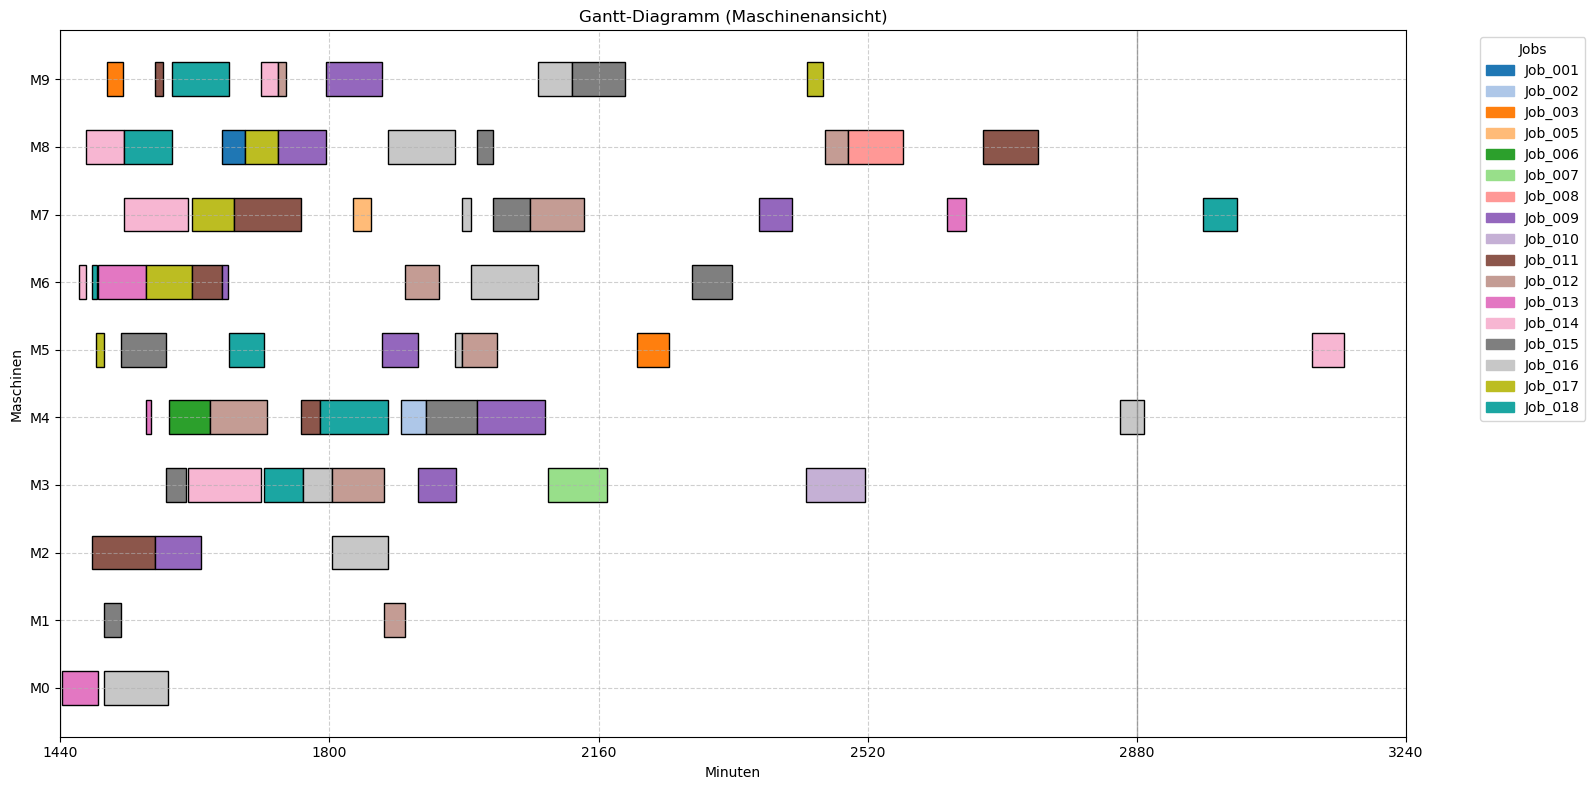

In [32]:
show.plot_gantt_machines(df_plan_prev_important)


Solver-Status         : OPTIMAL
Objective Value       : 70.00
Best Objective Bound  : 70.00
Laufzeit              : 2.16 Sekunden

  Scheduling-Dauer: 0 Minuten und 2.34 Sekunden.


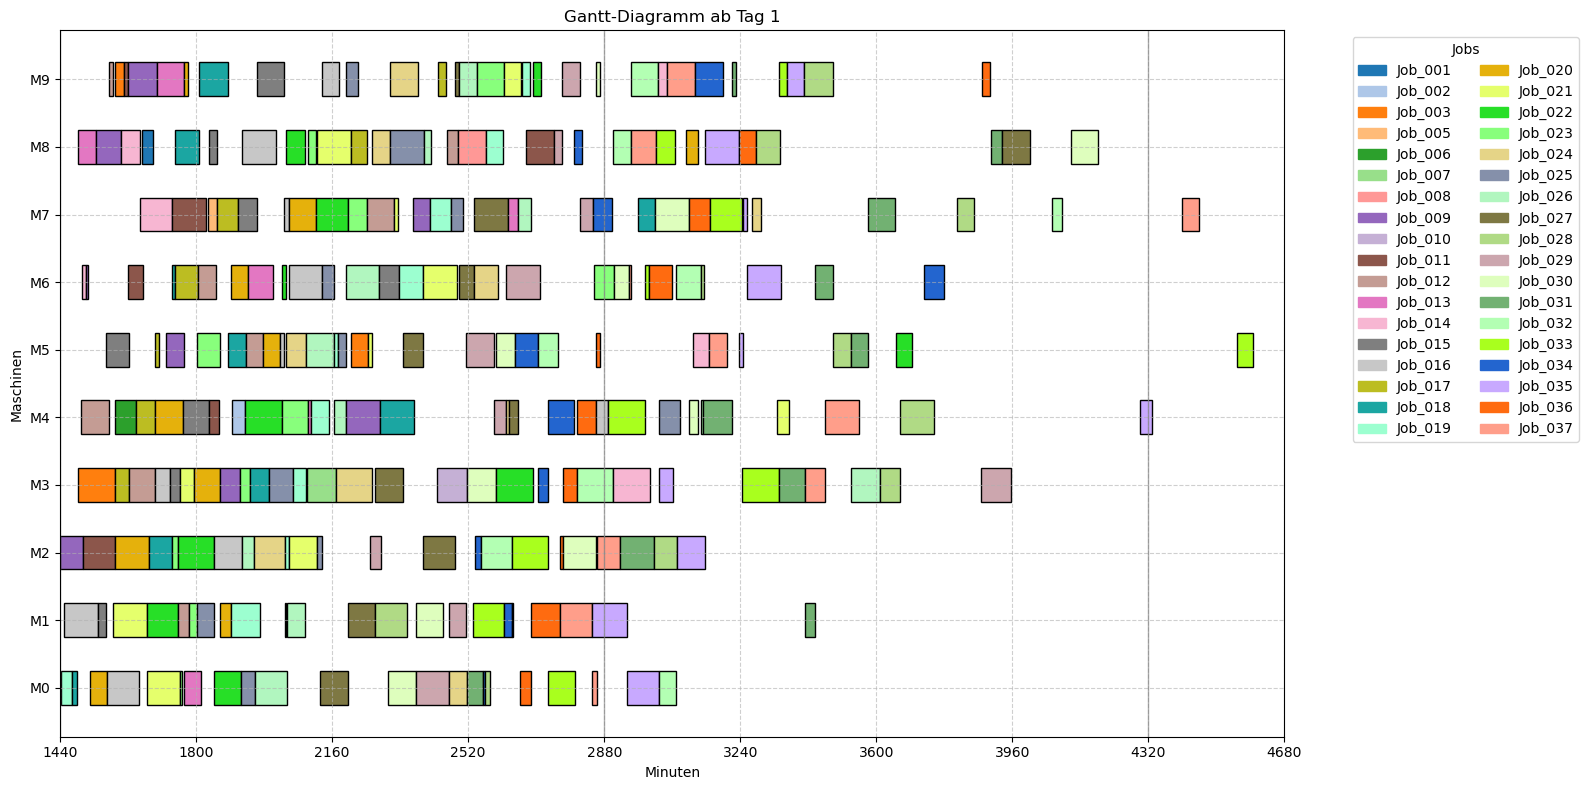

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              34
0 - 60          0
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[24:00:00] Job_009 started on M2
[24:02:00] Job_019 started on M0
[24:09:00] Job_016 started on M1
[24:37:57] Job_019 finished on M0 (after 35 minutes 58 seconds)
[24:37:57] Job_018 started on M0
[24:46:17] Job_018 finished on M0 (after 08 minutes 20 seconds)
[24:48:00] Job_003 started on M3
[24:48:00] Job_013 started on M8
[24:54:00] Job_012 started on M4
[24:55:01] Job_009 finished on M2 (after 55 minutes 02 seconds)
[24:59:00] Job_014 started on M6
[25:01:00] Job_011 started on M2
[25:12:34] Job_014 finished on M6 (after 13 minutes 34 seconds)
[25:1

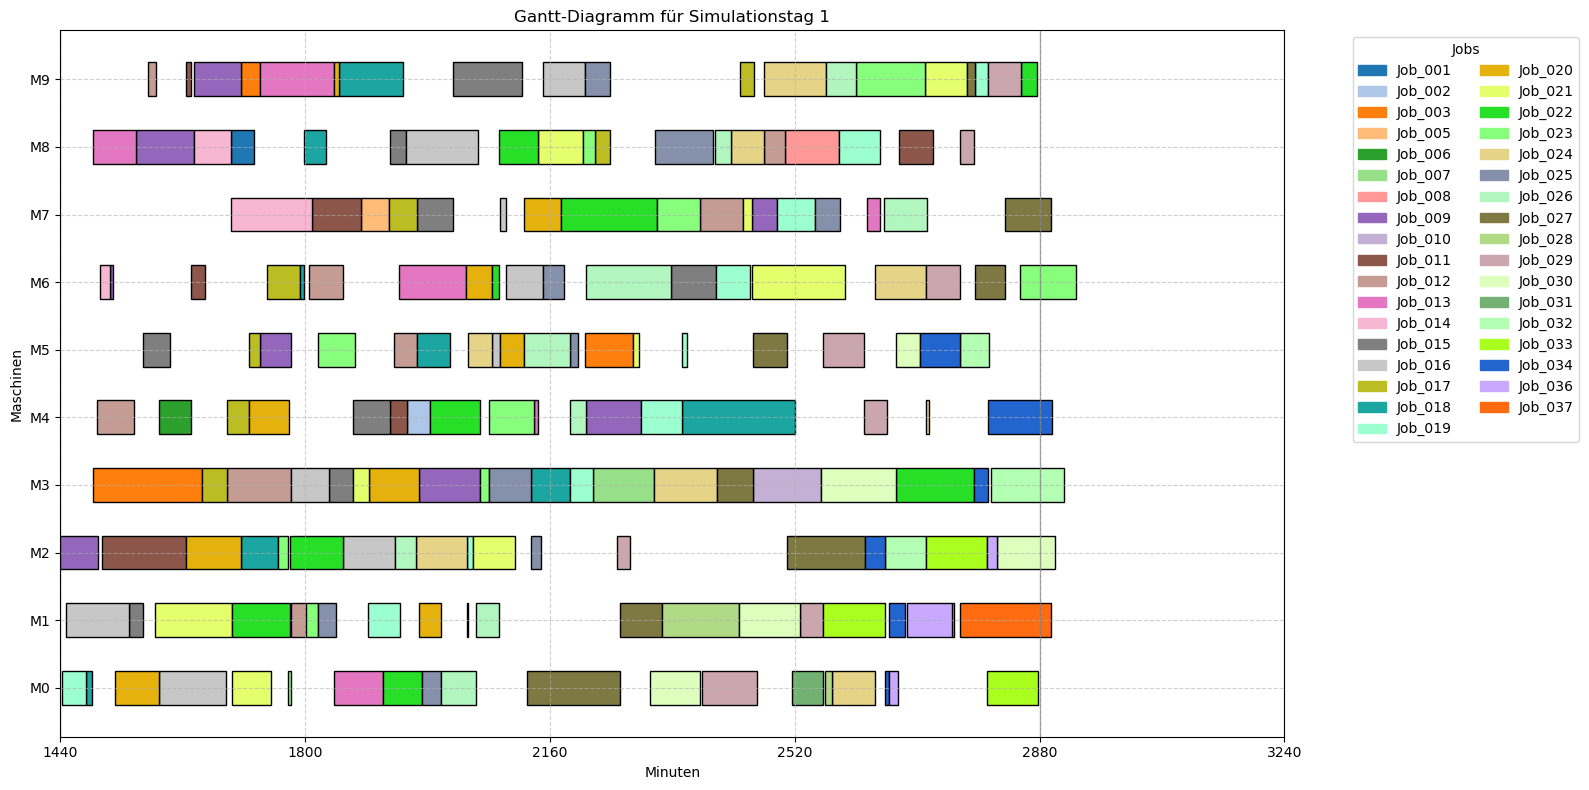

Not executed operations: 12
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 280.00
Best Objective Bound  : 280.00
Laufzeit              : 2.56 Sekunden

  Scheduling-Dauer: 0 Minuten und 2.75 Sekunden.


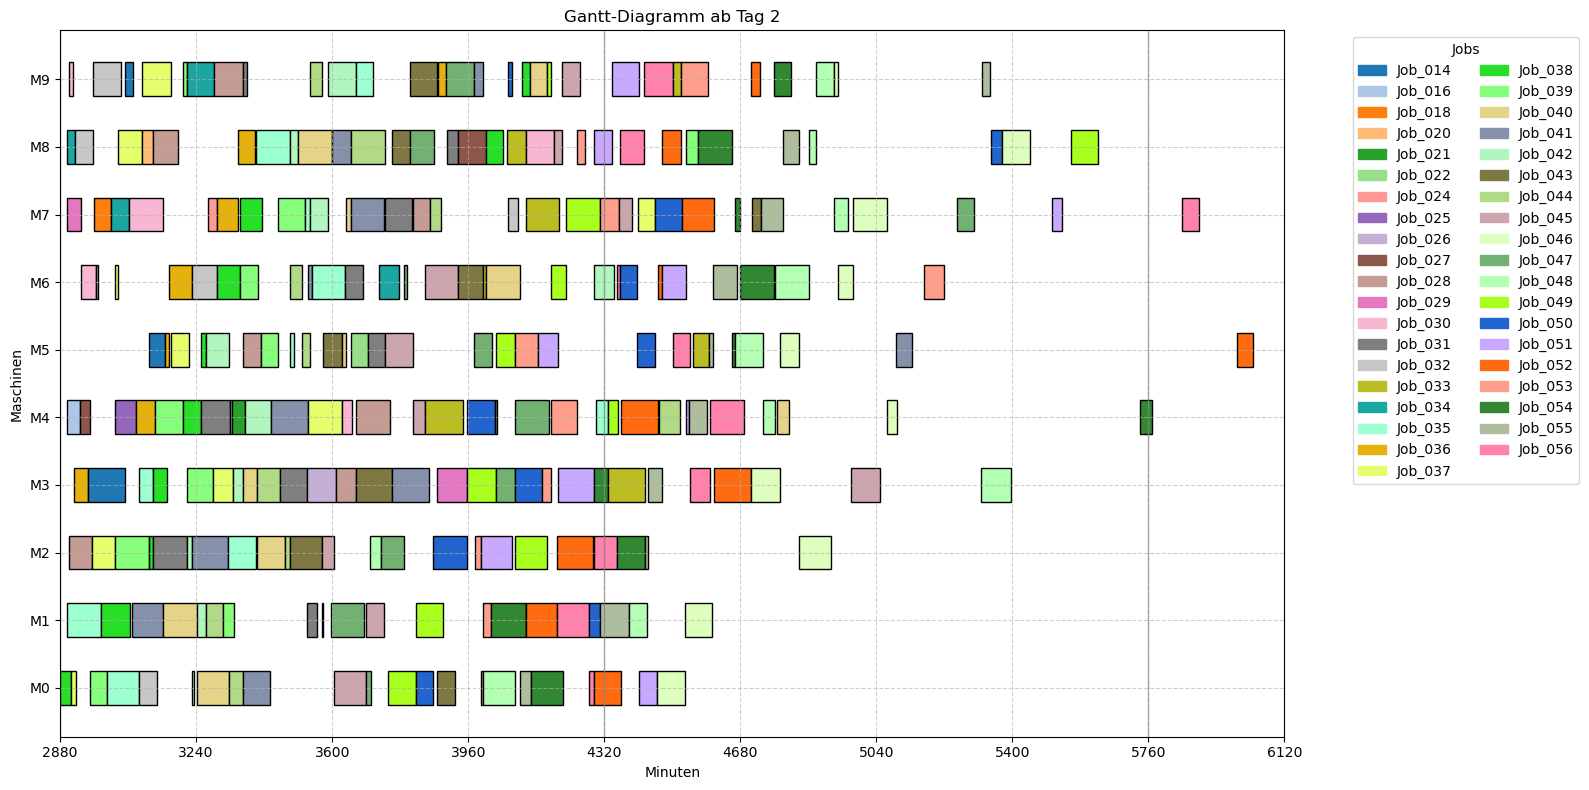

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              36
0 - 60          1
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[48:00:00] Job_038 started on M0
[48:17:00] Job_035 started on M1
[48:18:00] Job_029 started on M7
[48:19:00] Job_016 started on M4
[48:19:00] Job_034 started on M8
[48:19:04] Job_038 finished on M0 (after 19 minutes 05 seconds)
[48:24:00] Job_028 started on M2
[48:24:00] Job_030 started on M9
[48:29:00] Job_037 started on M0
[48:37:00] Job_036 started on M3
[48:42:19] Job_016 finished on M4 (after 23 minutes 19 seconds)
[48:42:55] Job_034 finished on M8 (after 23 minutes 56 seconds)
[48:42:55] Job_032 started on M8
[48:44:12] Job_030 finished on M9 (a

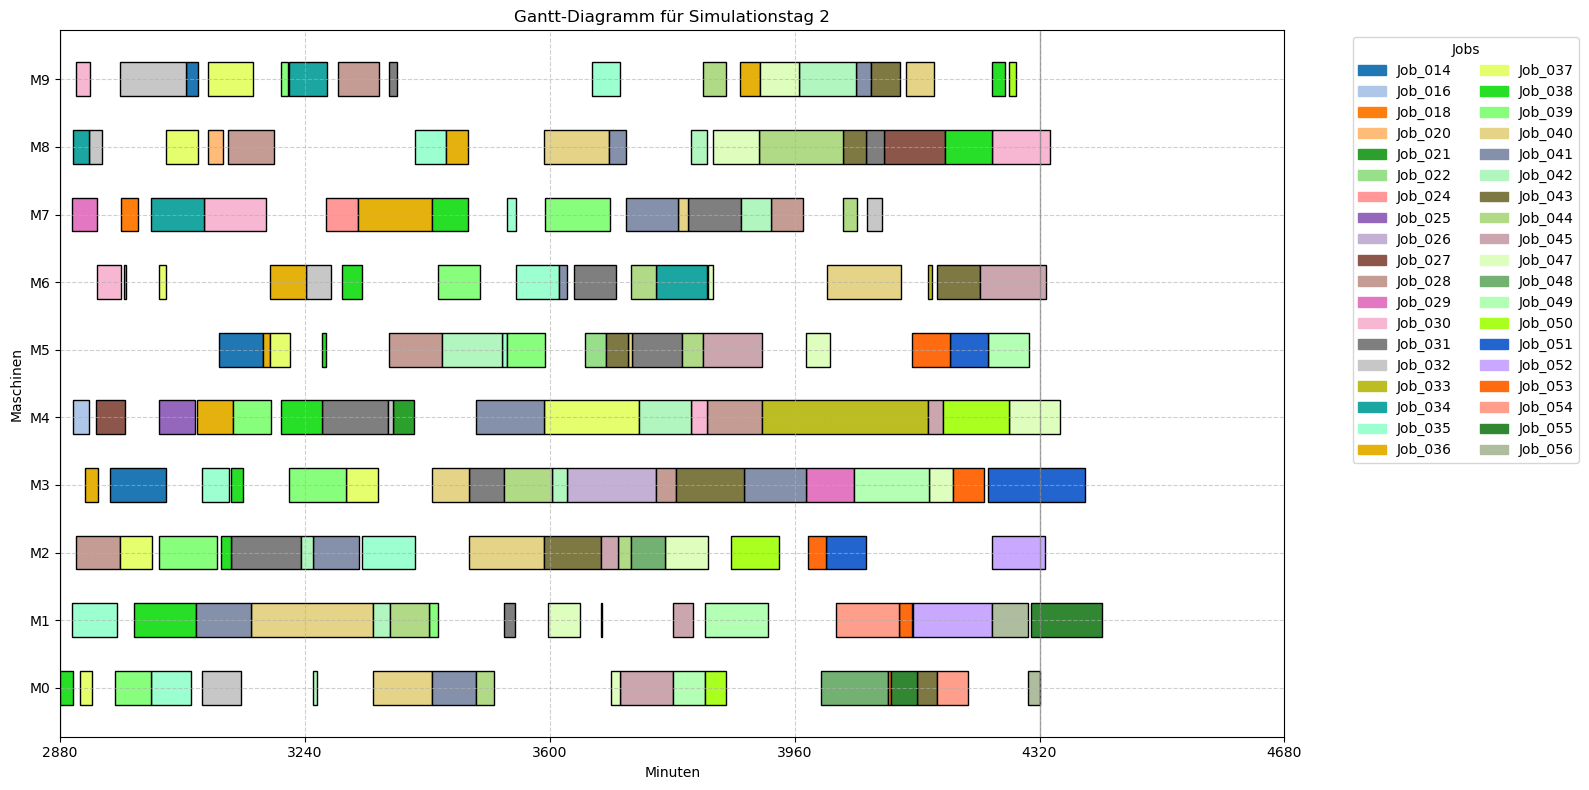

Not executed operations: 20
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 787.00
Best Objective Bound  : 787.00
Laufzeit              : 3.01 Sekunden

  Scheduling-Dauer: 0 Minuten und 3.21 Sekunden.


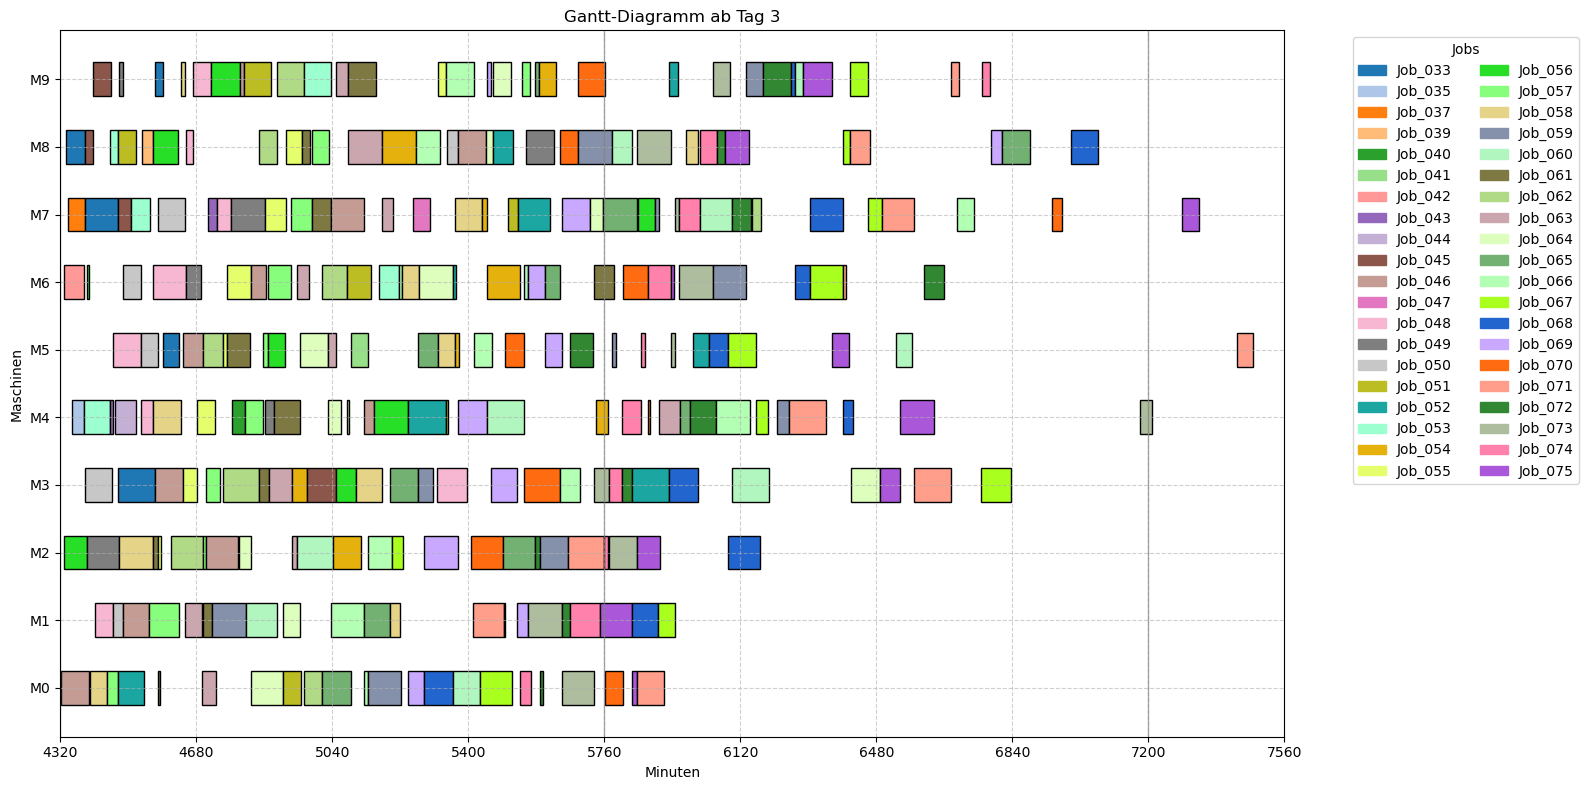

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      1
-60 - 0         2
0              34
0 - 60          3
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[72:01:00] Job_046 started on M0
[72:09:00] Job_056 started on M2
[72:10:00] Job_042 started on M6
[72:15:00] Job_033 started on M8
[72:22:00] Job_037 started on M7
[72:31:00] Job_035 started on M4
[72:50:30] Job_046 finished on M0 (after 49 minutes 30 seconds)
[72:58:11] Job_035 finished on M4 (after 27 minutes 11 seconds)
[73:04:00] Job_053 started on M4
[73:07:00] Job_050 started on M3
[73:12:55] Job_042 finished on M6 (after 62 minutes 56 seconds)
[73:14:15] Job_056 finished on M2 (after 65 minutes 15 seconds)
[73:14:15] Job_049 started on M2
[73:1

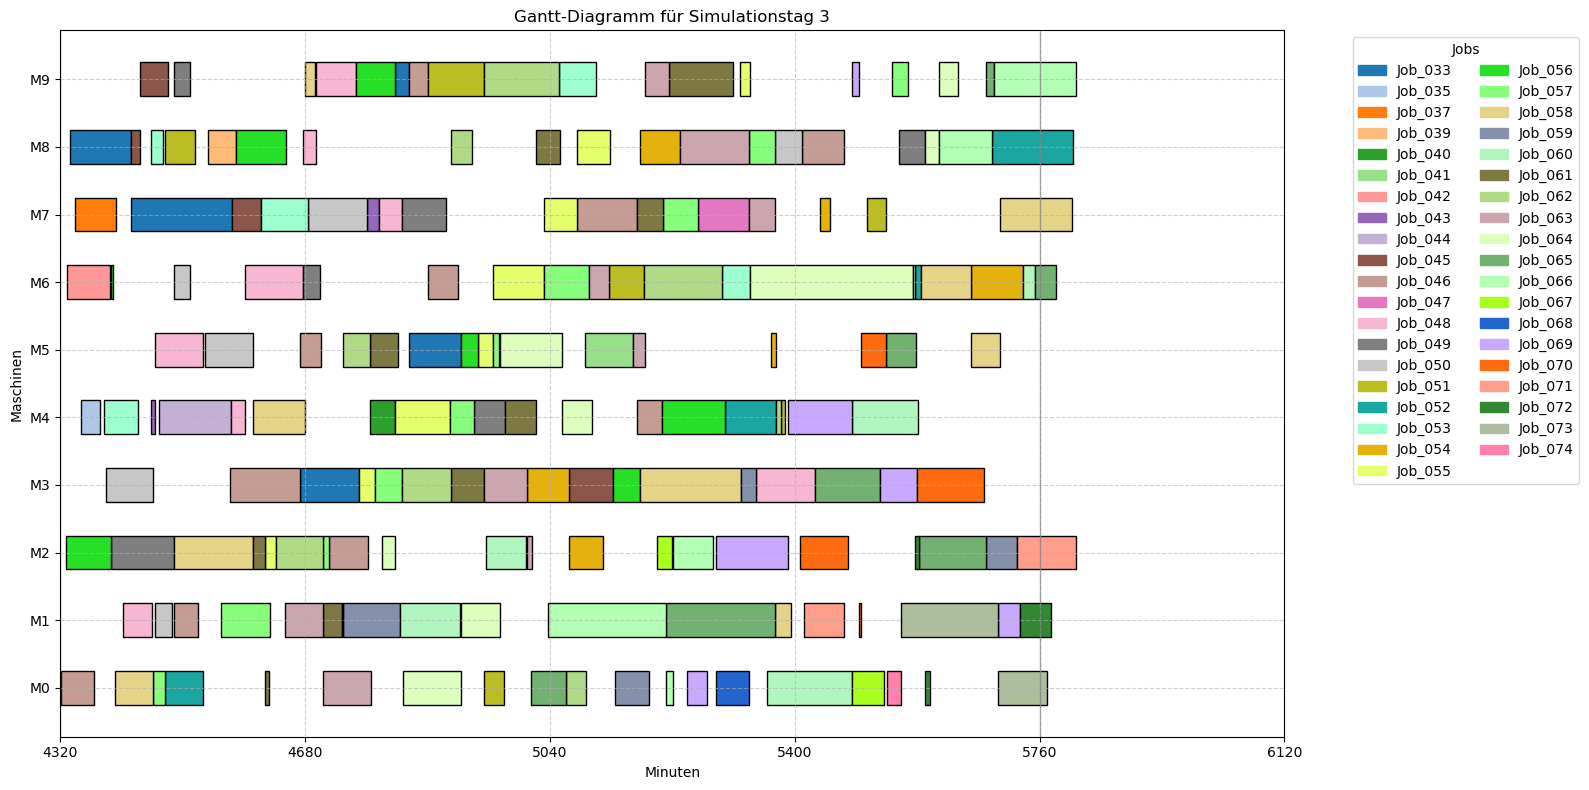

Not executed operations: 18
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 1260.00
Best Objective Bound  : 1260.00
Laufzeit              : 6.60 Sekunden

  Scheduling-Dauer: 0 Minuten und 6.72 Sekunden.


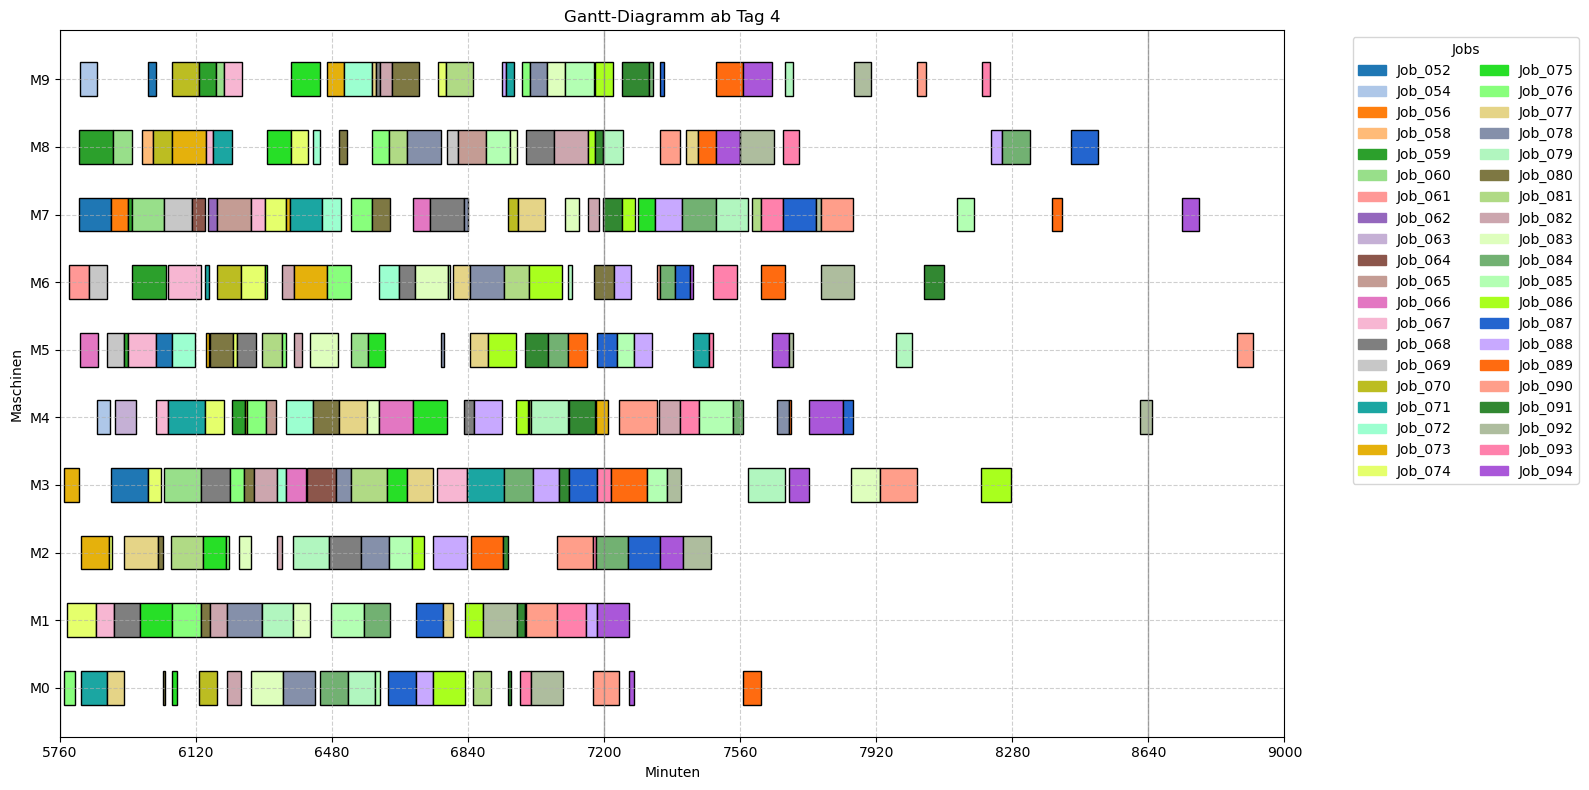

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              34
0 - 60          3
60 - 120        0
120 - 180       1
>180            0
Name: count, dtype: int32
[96:11:00] Job_073 started on M3
[96:11:00] Job_076 started on M0
[96:18:00] Job_074 started on M1
[96:24:00] Job_061 started on M6
[96:29:45] Job_076 finished on M0 (after 18 minutes 46 seconds)
[96:36:24] Job_073 finished on M3 (after 25 minutes 25 seconds)
[96:49:00] Job_052 started on M7
[96:49:00] Job_059 started on M8
[96:53:00] Job_054 started on M9
[96:53:00] Job_066 started on M5
[96:54:00] Job_071 started on M0
[96:54:00] Job_073 started on M2
[97:32:10] Job_054 finished on M9 (after 39 minutes 11 seconds)
[97:38:00] Job_054 started on M4
[97

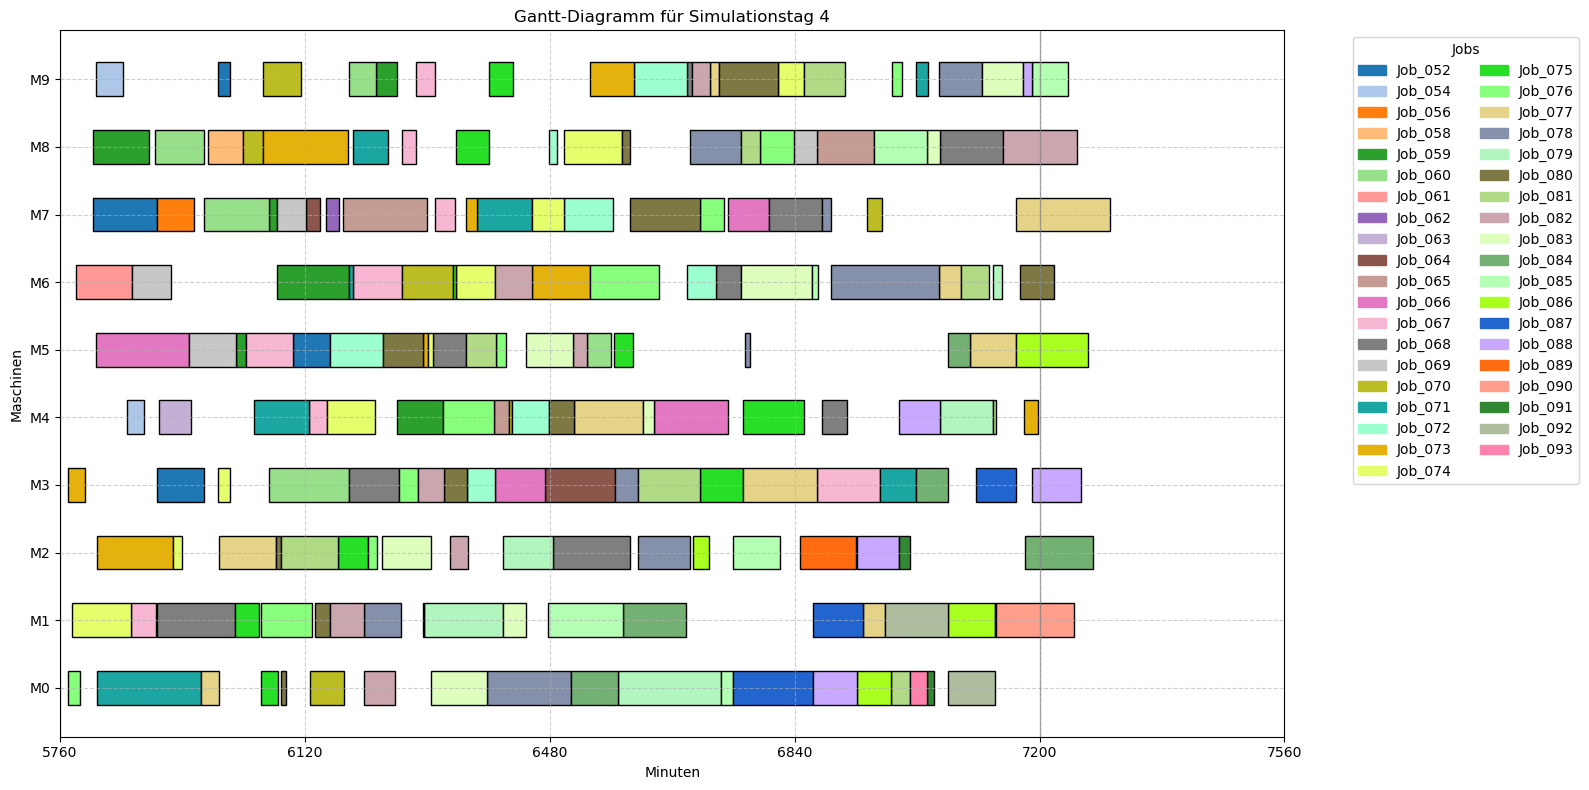

Not executed operations: 22
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 295.00
Best Objective Bound  : 295.00
Laufzeit              : 4.69 Sekunden

  Scheduling-Dauer: 0 Minuten und 4.88 Sekunden.


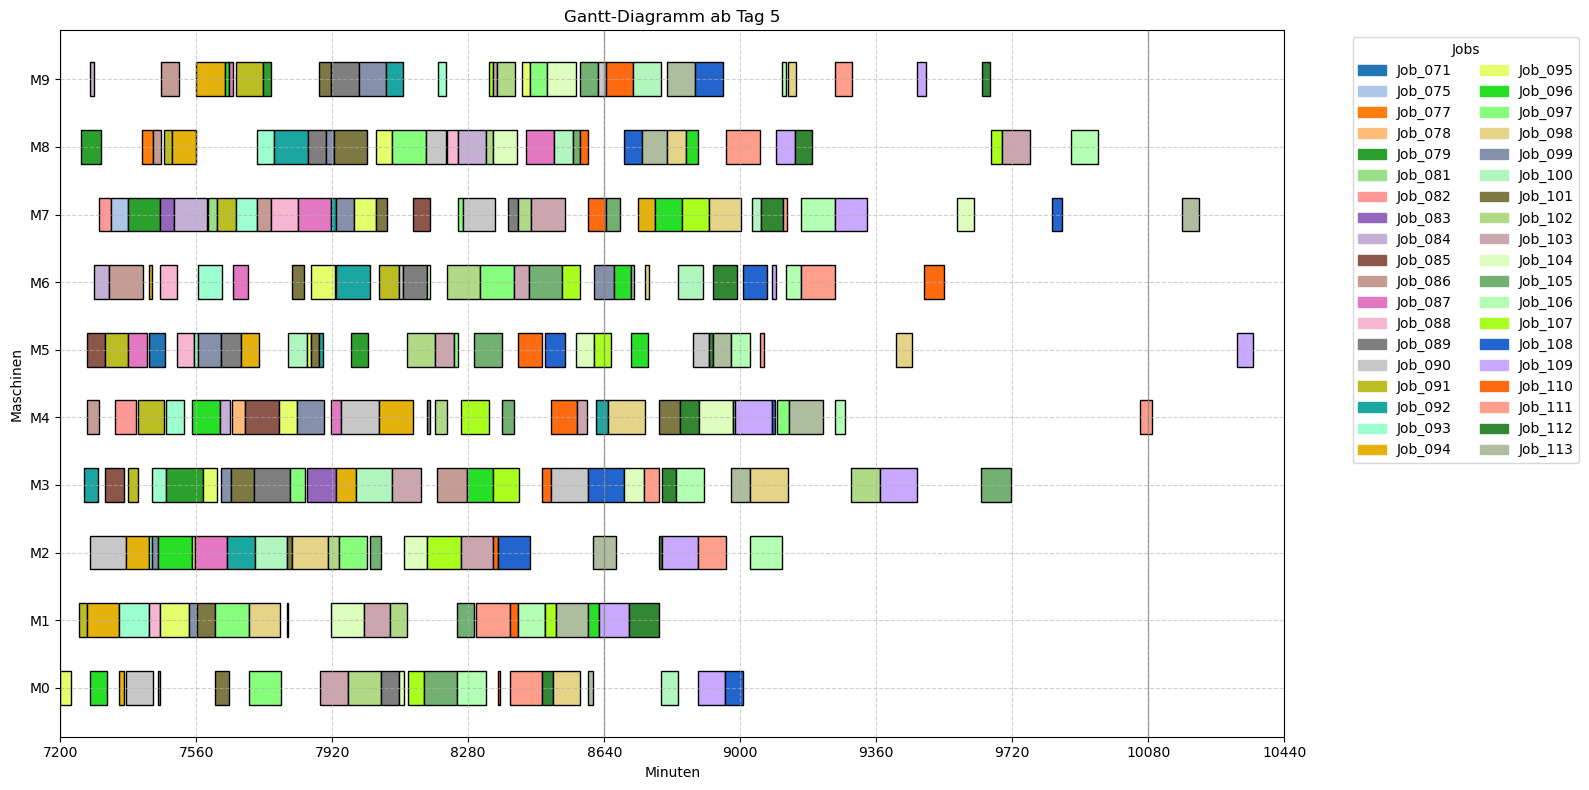

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              35
0 - 60          1
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[120:00:00] Job_095 started on M0
[120:40:26] Job_095 finished on M0 (after 40 minutes 27 seconds)
[120:50:00] Job_091 started on M1
[120:55:00] Job_079 started on M8
[121:01:00] Job_091 finished on M1 (after 11 minutes)
[121:02:00] Job_092 started on M3
[121:11:00] Job_085 started on M5
[121:11:00] Job_086 started on M4
[121:12:00] Job_094 started on M1
[121:19:00] Job_084 started on M9
[121:19:00] Job_090 started on M2
[121:20:00] Job_096 started on M0
[121:21:28] Job_092 finished on M3 (after 19 minutes 29 seconds)
[121:21:46] Job_086 finished on M4

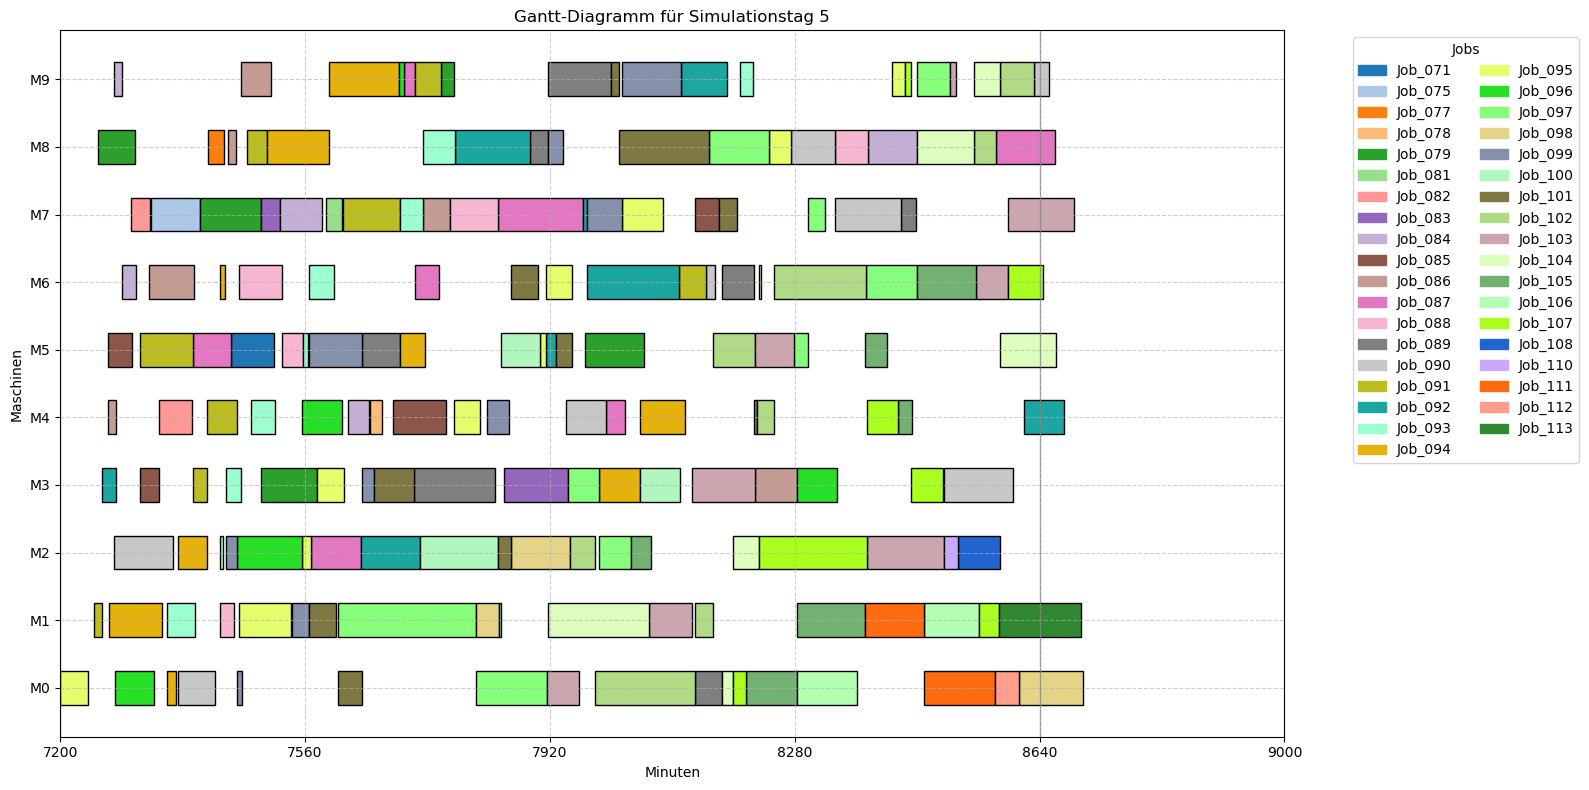

Not executed operations: 21
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 420.00
Best Objective Bound  : 420.00
Laufzeit              : 3.35 Sekunden

  Scheduling-Dauer: 0 Minuten und 3.54 Sekunden.


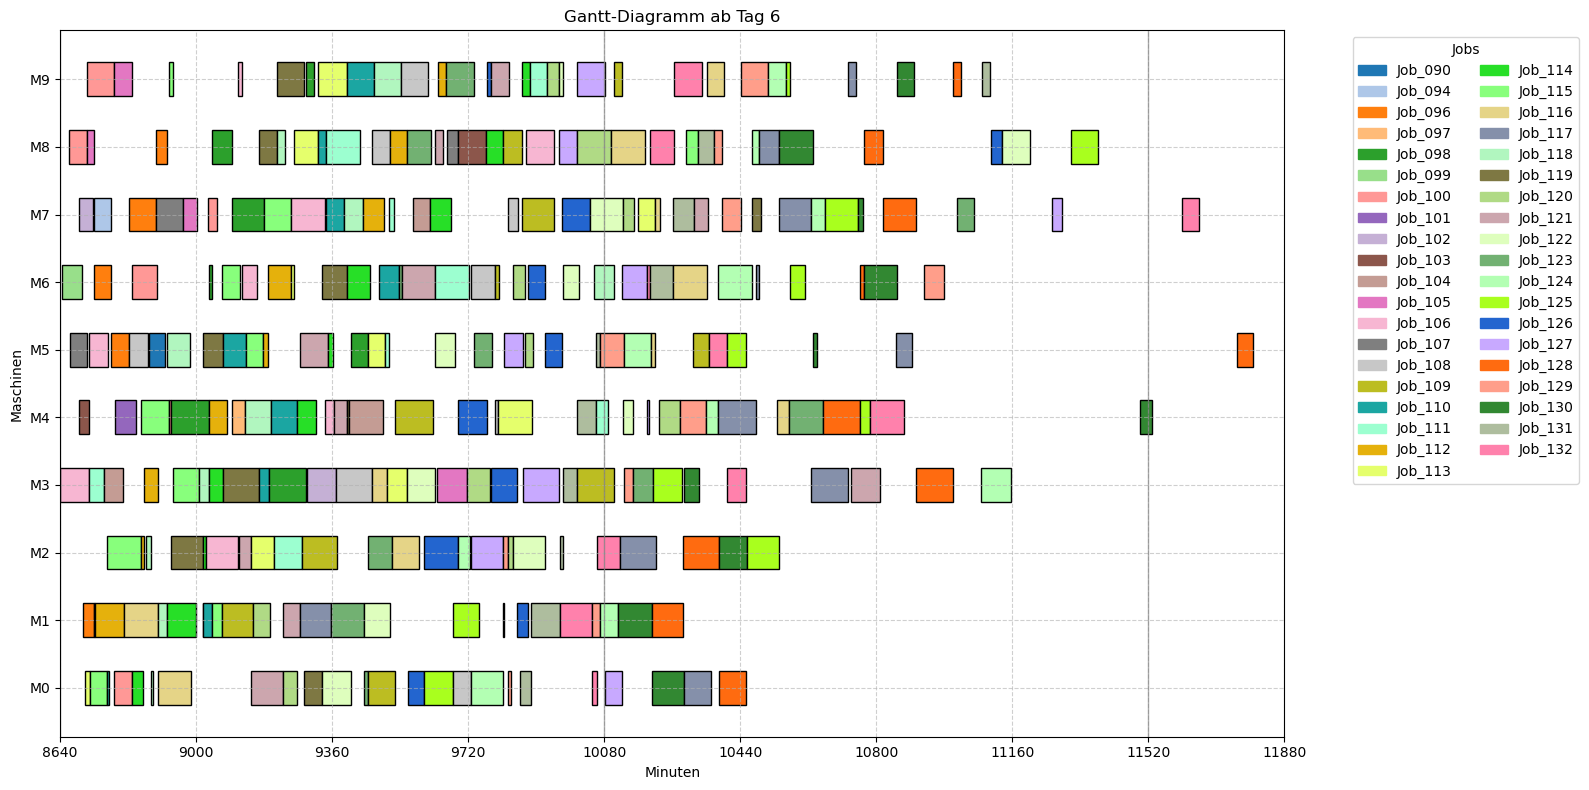

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              35
0 - 60          2
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[144:00:00] Job_106 started on M3
[144:06:00] Job_099 started on M6
[144:23:00] Job_100 started on M8
[144:25:00] Job_107 started on M5
[144:41:38] Job_099 finished on M6 (after 35 minutes 38 seconds)
[144:51:00] Job_102 started on M7
[144:51:00] Job_103 started on M4
[144:51:04] Job_100 finished on M8 (after 28 minutes 05 seconds)
[145:01:00] Job_096 started on M1
[145:04:22] Job_107 finished on M5 (after 39 minutes 23 seconds)
[145:05:00] Job_113 started on M0
[145:10:21] Job_103 finished on M4 (after 19 minutes 21 seconds)
[145:11:00] Job_105 starte

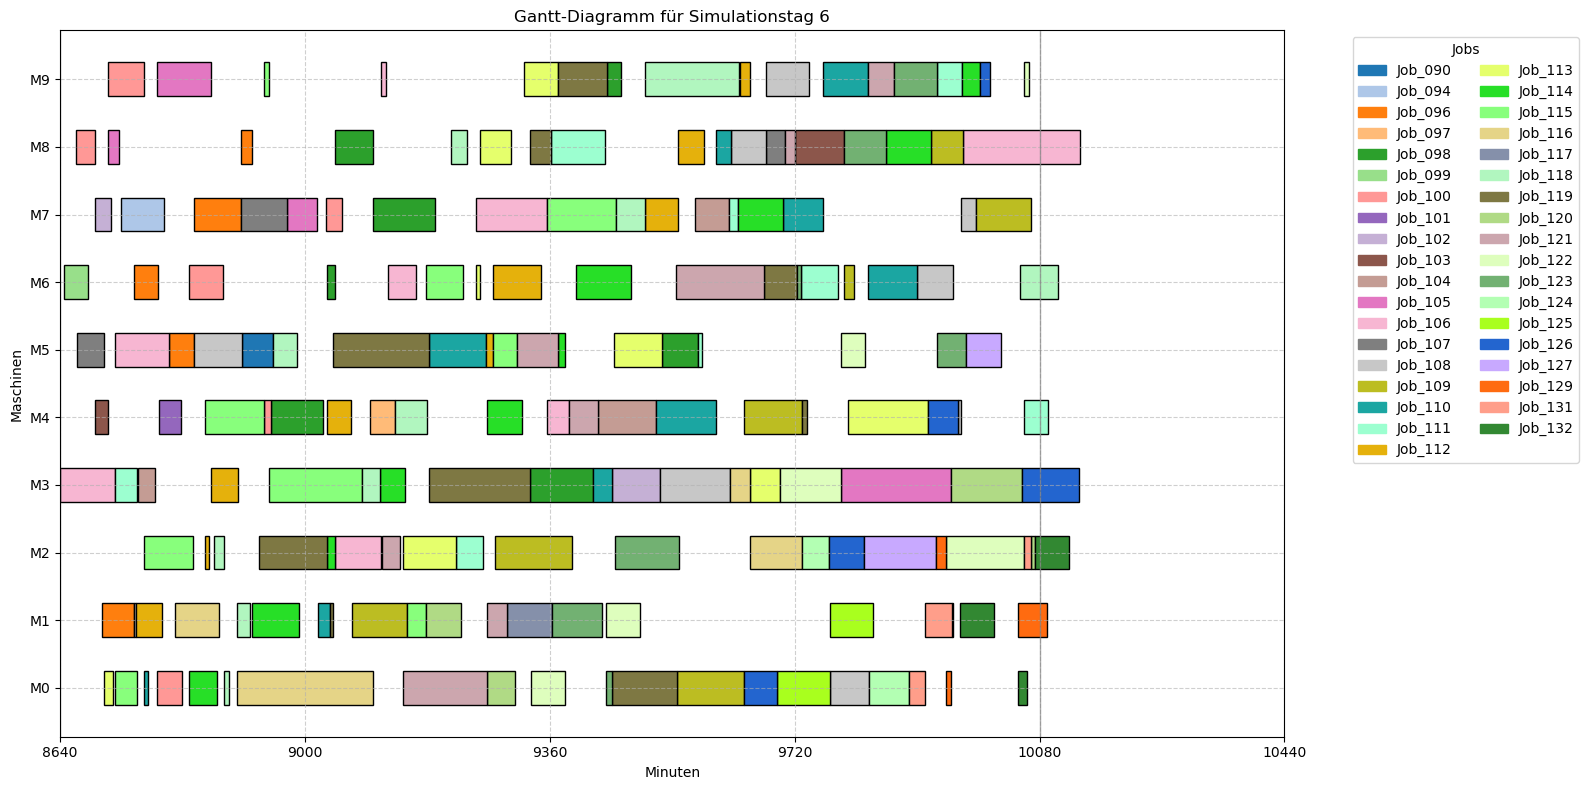

Not executed operations: 19
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 634.00
Best Objective Bound  : 634.00
Laufzeit              : 9.38 Sekunden

  Scheduling-Dauer: 0 Minuten und 9.55 Sekunden.


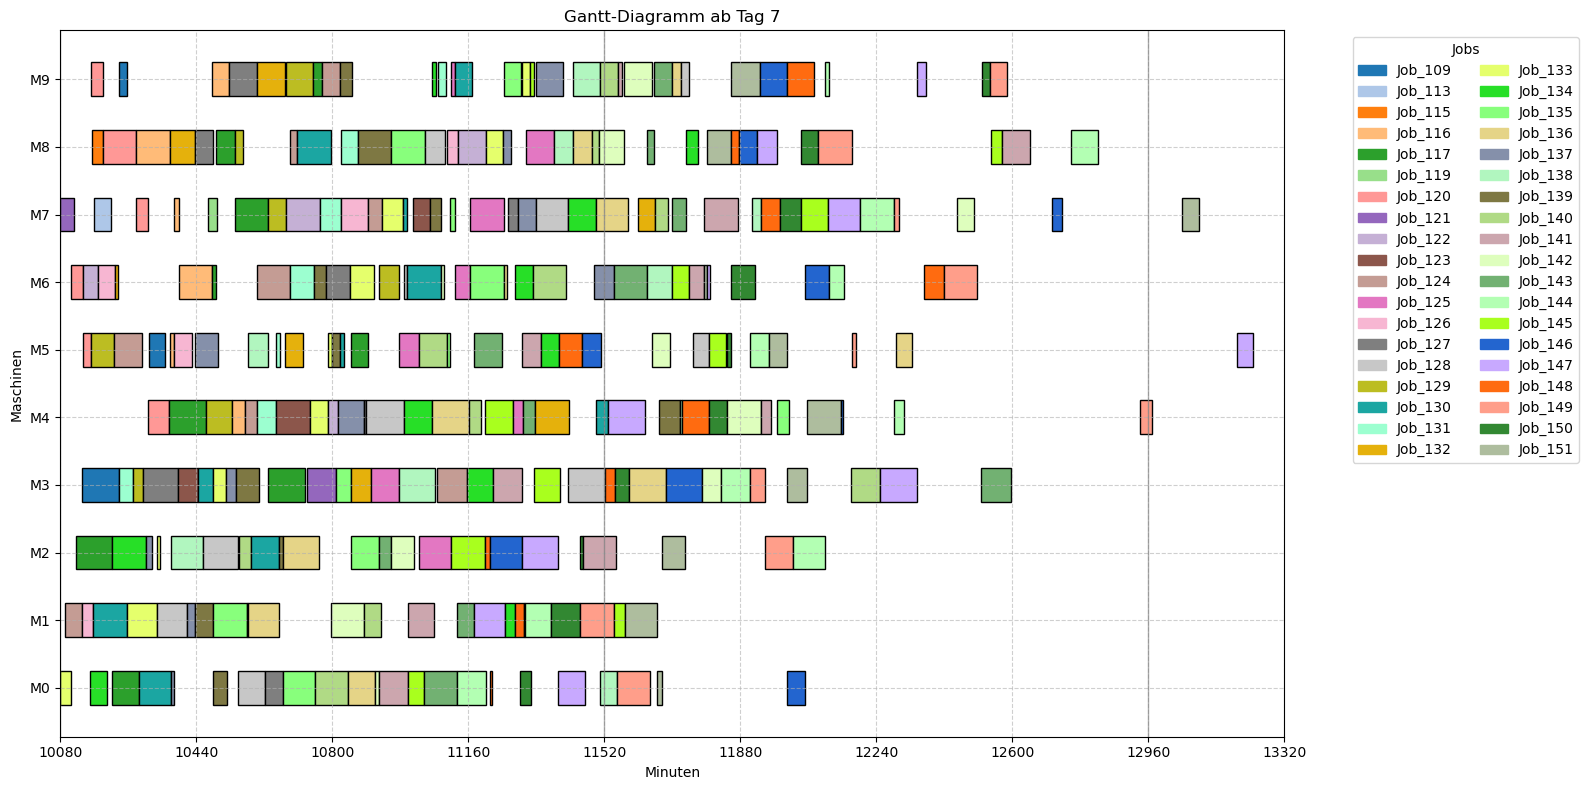

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     1
-120 - -60      0
-60 - 0         2
0              34
0 - 60          0
60 - 120        1
120 - 180       0
>180            0
Name: count, dtype: int32
[168:00:00] Job_121 started on M7
[168:00:00] Job_133 started on M0
[168:12:00] Job_124 started on M1
[168:18:50] Job_133 finished on M0 (after 18 minutes 50 seconds)
[168:28:00] Job_120 started on M6
[168:43:00] Job_117 started on M2
[168:43:27] Job_121 finished on M7 (after 43 minutes 27 seconds)
[168:57:14] Job_124 finished on M1 (after 45 minutes 14 seconds)
[168:58:00] Job_109 started on M3
[168:58:00] Job_126 started on M1
[169:20:00] Job_134 started on M0
[169:21:00] Job_129 started on M5
[169:23:00] Job_115 started on M8
[169:29:00] Job_113 sta

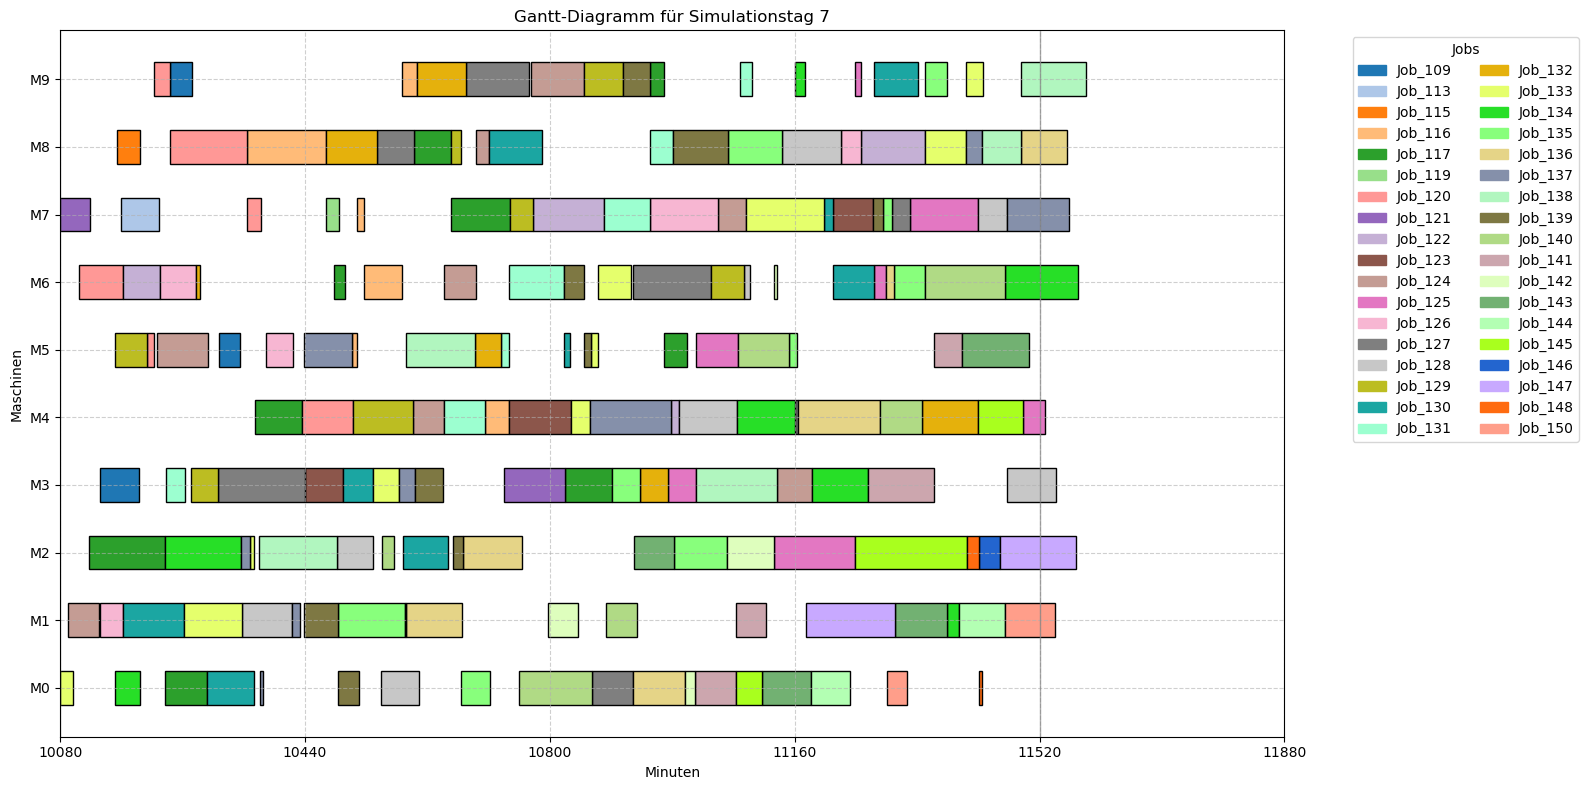

Not executed operations: 22
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 2310.00
Best Objective Bound  : 2310.00
Laufzeit              : 6.81 Sekunden

  Scheduling-Dauer: 0 Minuten und 7.01 Sekunden.


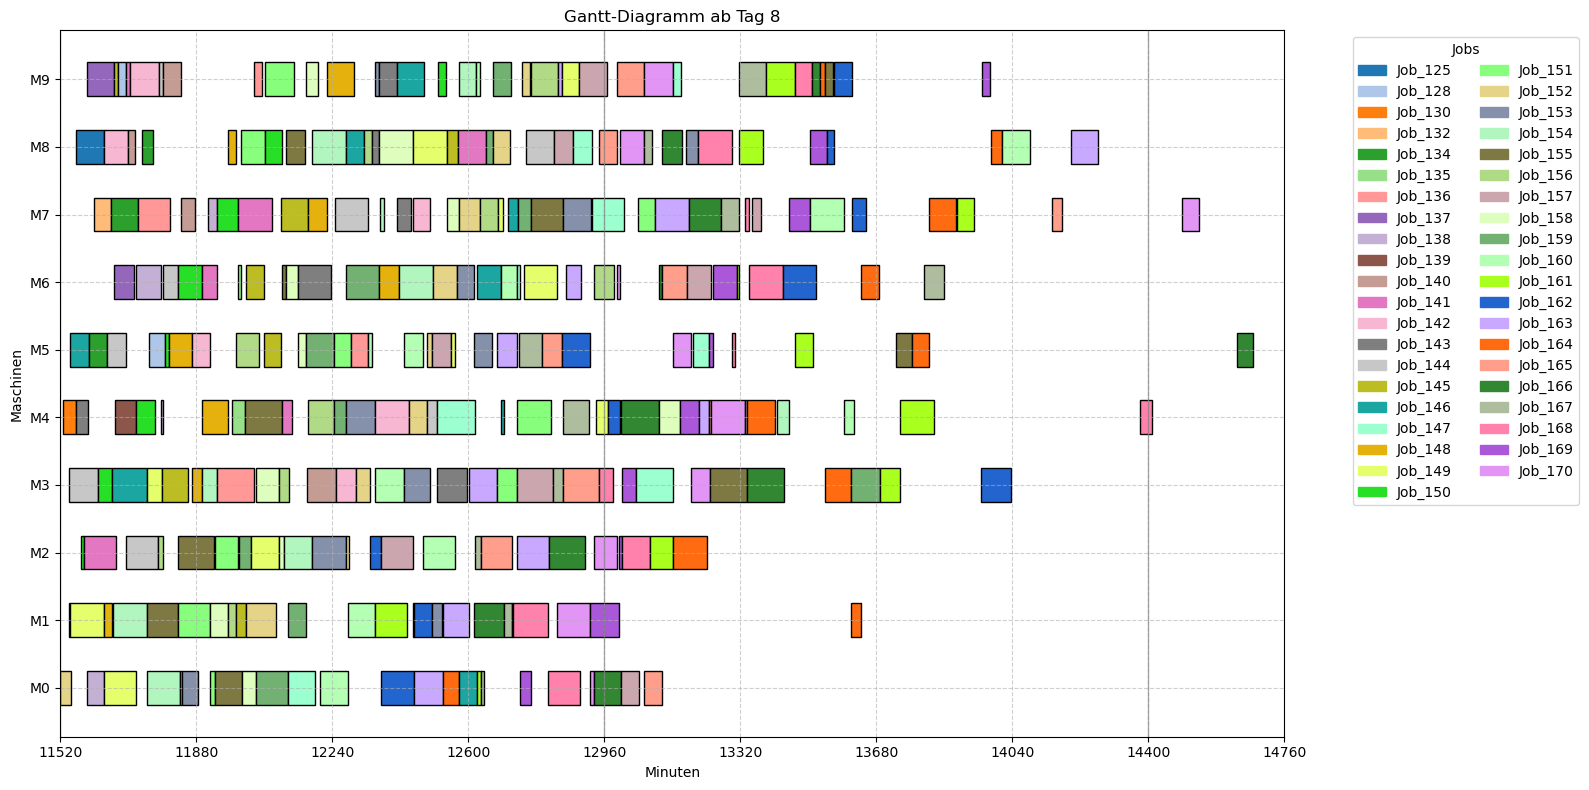

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              36
0 - 60          1
60 - 120        0
120 - 180       1
>180            1
Name: count, dtype: int32
[192:00:00] Job_152 started on M0
[192:08:00] Job_130 started on M4
[192:23:00] Job_146 started on M1
[192:23:53] Job_130 finished on M4 (after 15 minutes 54 seconds)
[192:24:00] Job_144 started on M3
[192:24:23] Job_146 finished on M1 (after 01 minute 24 seconds)
[192:25:00] Job_149 started on M1
[192:25:00] Job_146 started on M5
[192:38:29] Job_152 finished on M0 (after 38 minutes 29 seconds)
[192:41:00] Job_125 started on M8
[192:41:00] Job_143 started on M4
[192:55:00] Job_150 started on M2
[193:02:32] Job_146 finished on M5 (after 37 minutes 33 se

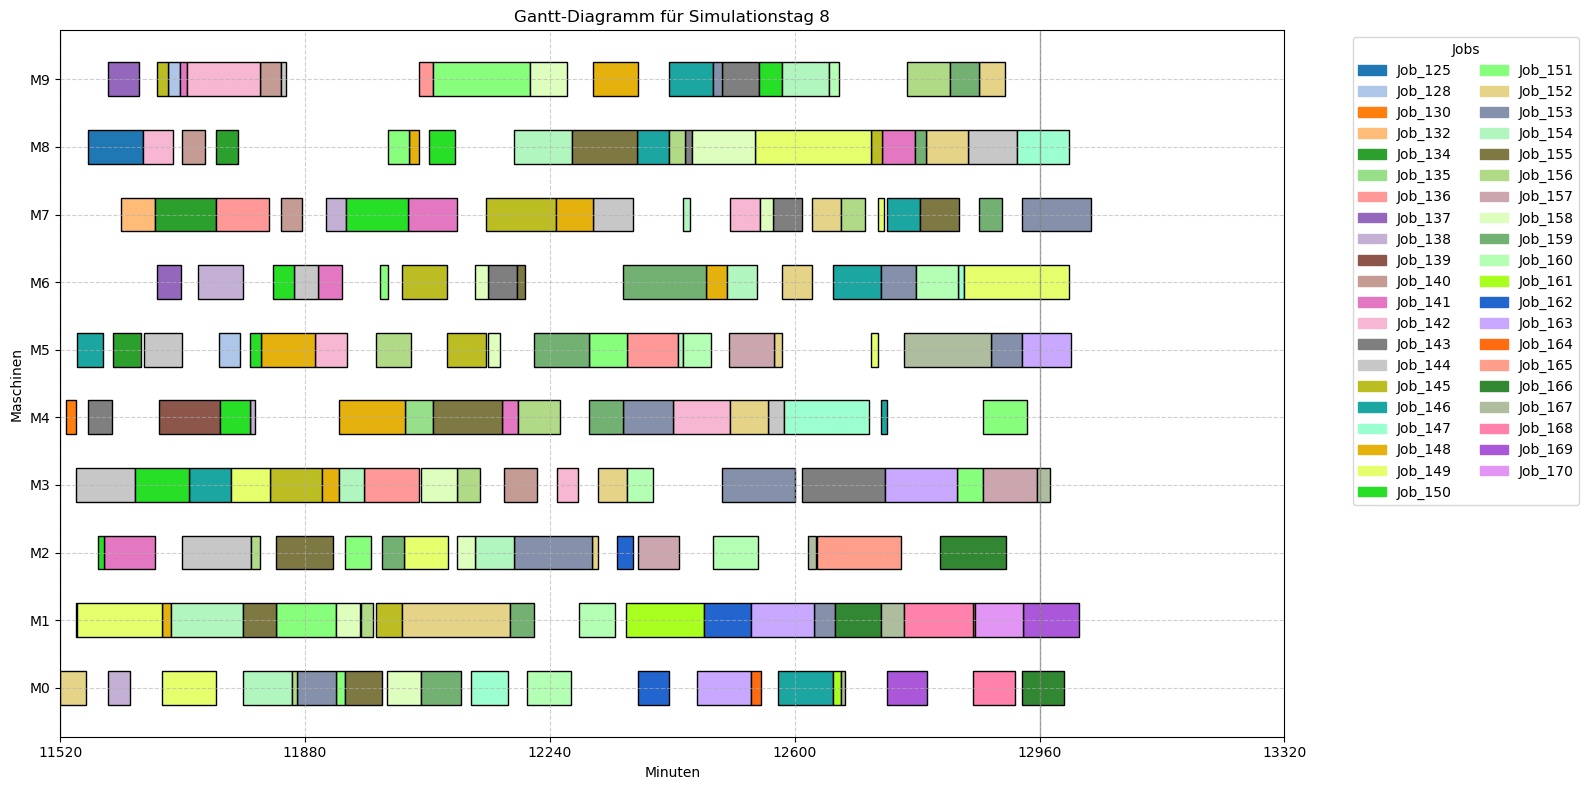

Not executed operations: 17
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 1467.00
Best Objective Bound  : 1467.00
Laufzeit              : 3.16 Sekunden

  Scheduling-Dauer: 0 Minuten und 3.32 Sekunden.


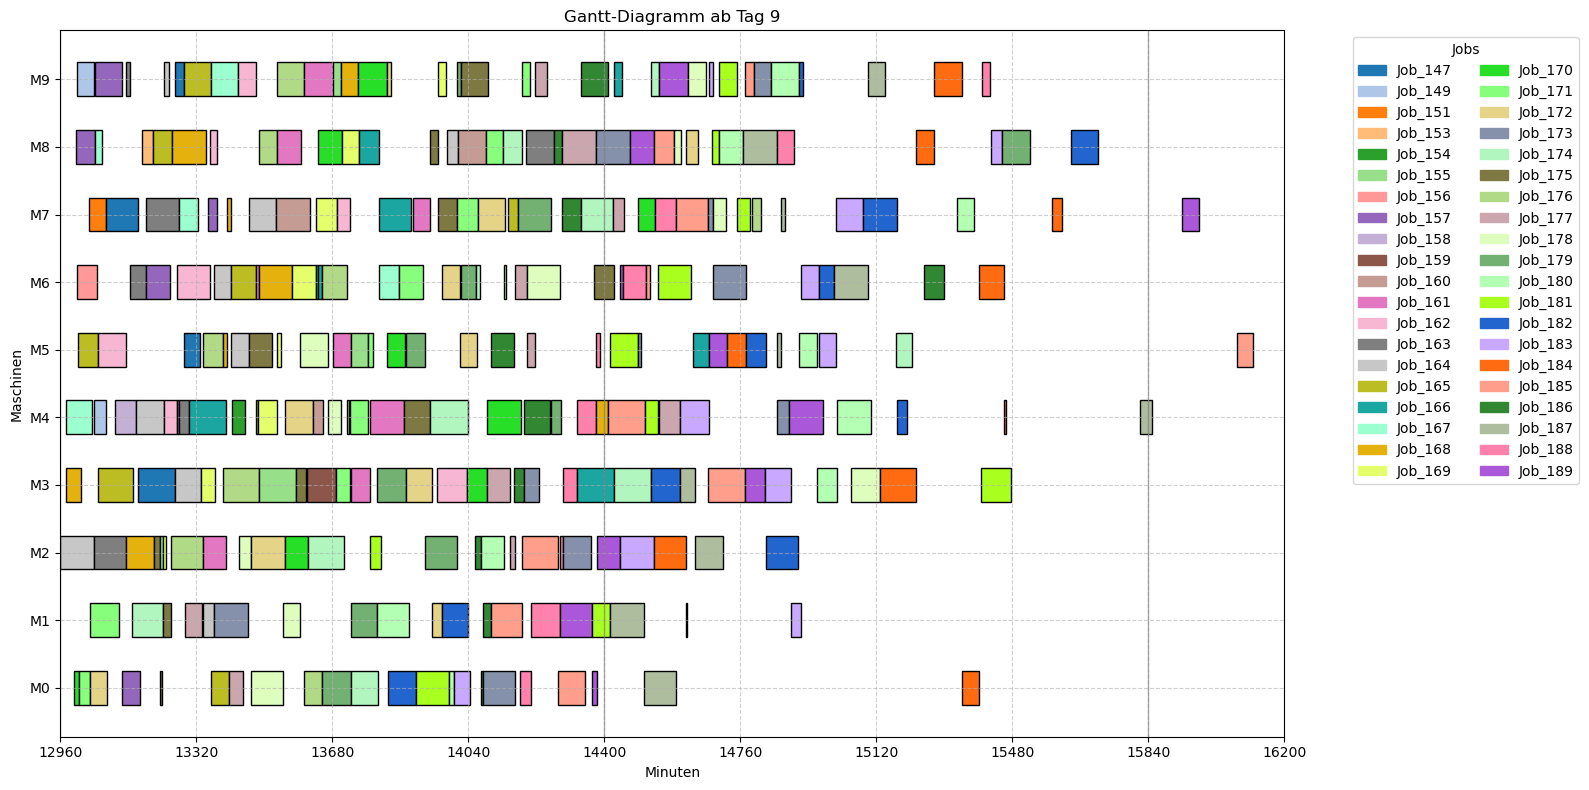

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              34
0 - 60          0
60 - 120        3
120 - 180       0
>180            0
Name: count, dtype: int32
[216:00:00] Job_164 started on M2
[216:15:00] Job_167 started on M4
[216:15:00] Job_168 started on M3
[216:37:00] Job_170 started on M0
[216:41:30] Job_168 finished on M3 (after 26 minutes 30 seconds)
[216:43:00] Job_157 started on M8
[216:44:00] Job_149 started on M9
[216:44:00] Job_156 started on M6
[216:47:00] Job_165 started on M5
[216:47:38] Job_164 finished on M2 (after 47 minutes 39 seconds)
[216:52:00] Job_170 finished on M0 (after 15 minutes 01 second)
[216:52:00] Job_171 started on M0
[217:04:04] Job_171 finished on M0 (after 12 minutes 04 se

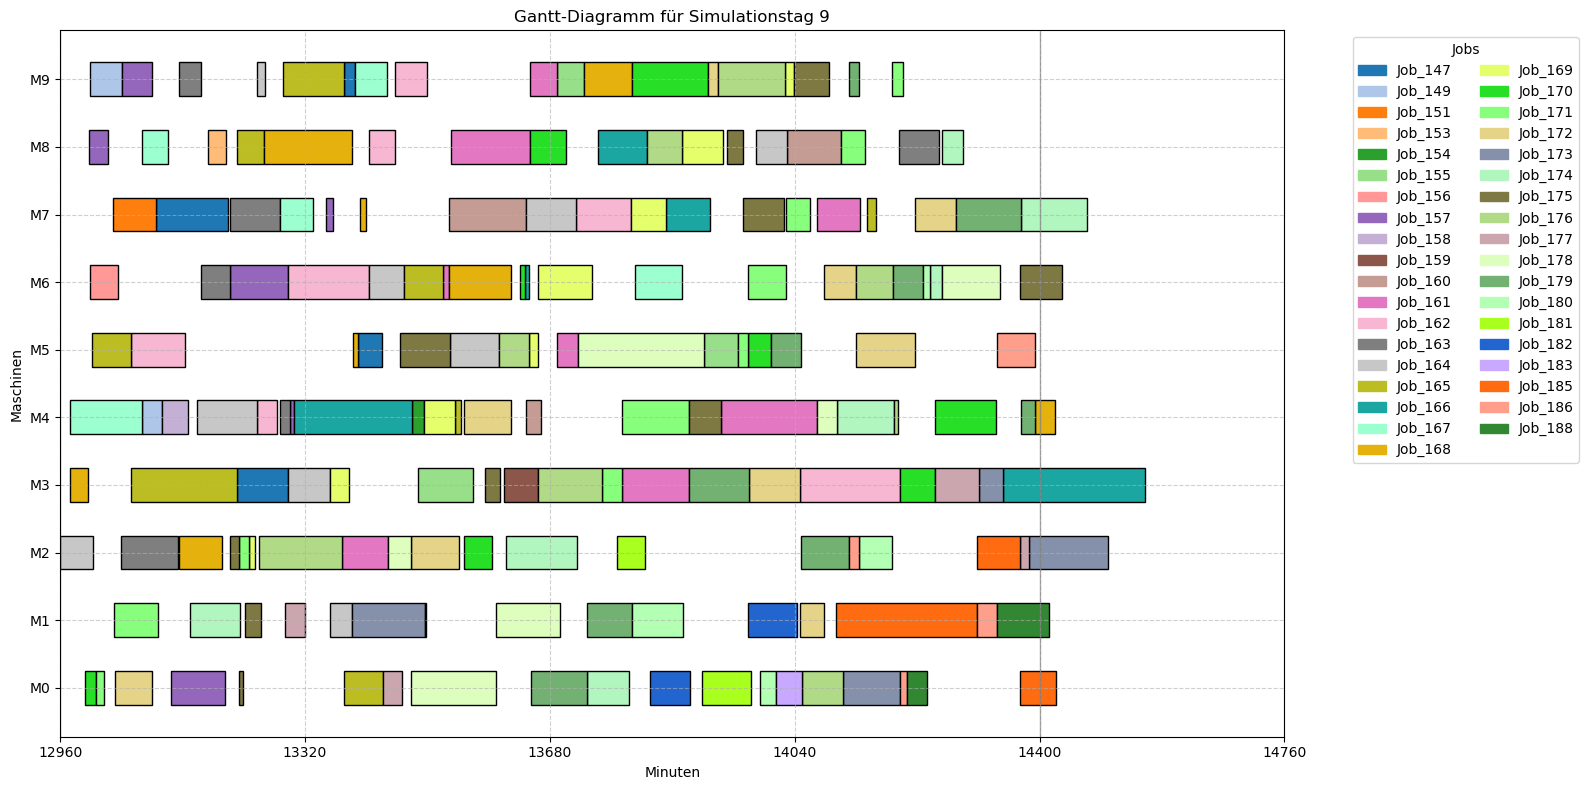

Not executed operations: 18
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 658.00
Best Objective Bound  : 658.00
Laufzeit              : 6.26 Sekunden

  Scheduling-Dauer: 0 Minuten und 6.44 Sekunden.


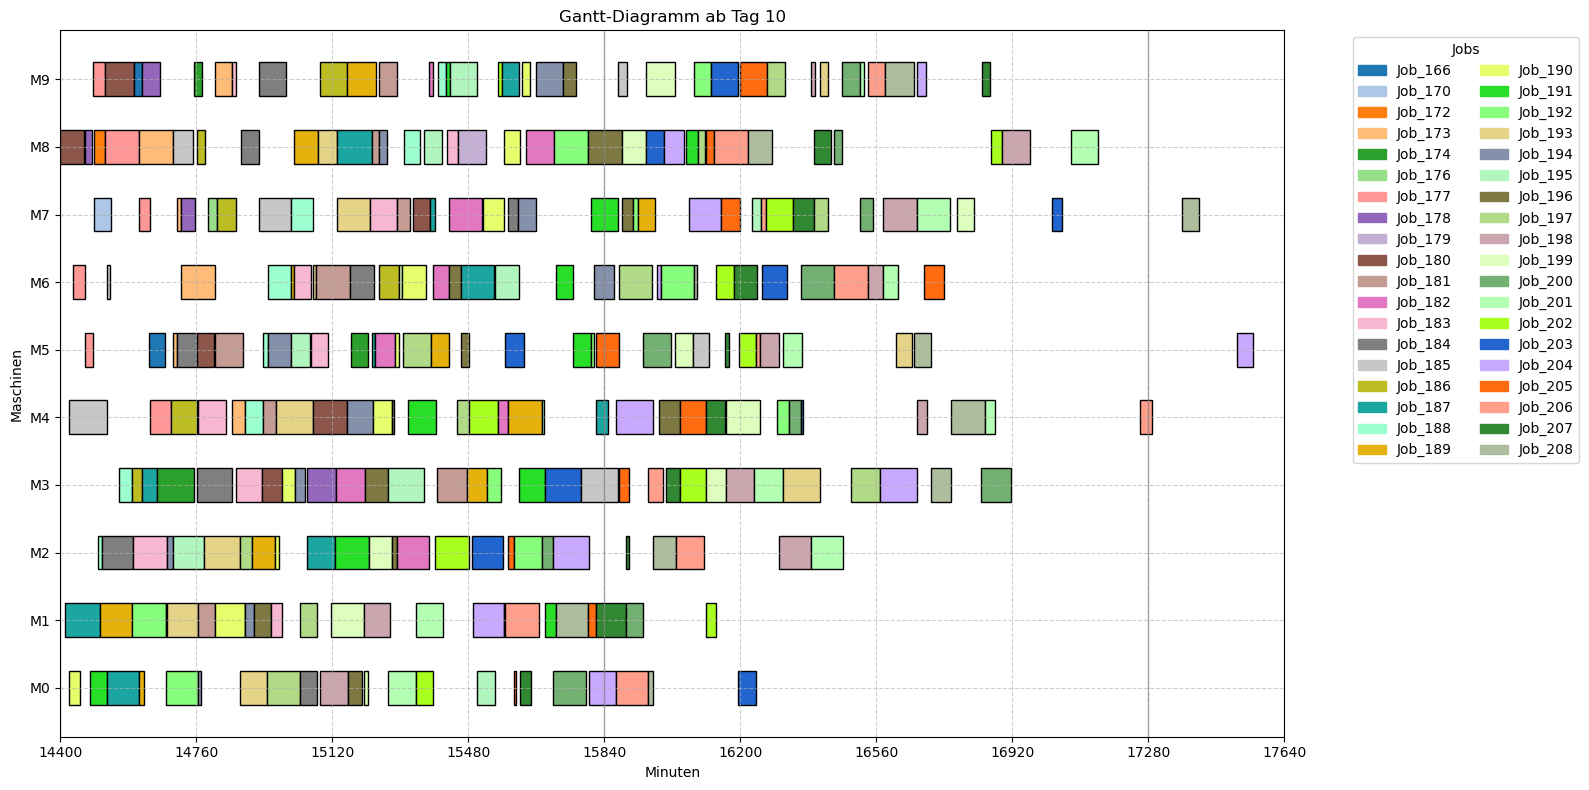

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     1
-120 - -60      0
-60 - 0         2
0              34
0 - 60          0
60 - 120        1
120 - 180       0
>180            0
Name: count, dtype: int32
[240:00:00] Job_180 started on M8
[240:14:00] Job_187 started on M1
[240:24:00] Job_185 started on M4
[240:24:00] Job_190 started on M0
[240:32:51] Job_180 finished on M8 (after 32 minutes 52 seconds)
[240:34:00] Job_177 started on M6
[240:51:56] Job_190 finished on M0 (after 27 minutes 56 seconds)
[241:03:47] Job_177 finished on M6 (after 29 minutes 47 seconds)
[241:05:00] Job_178 started on M8
[241:06:00] Job_177 started on M5
[241:17:33] Job_178 finished on M8 (after 12 minutes 34 seconds)
[241:20:00] Job_191 started on M0
[241:20:24] Job_187 finish

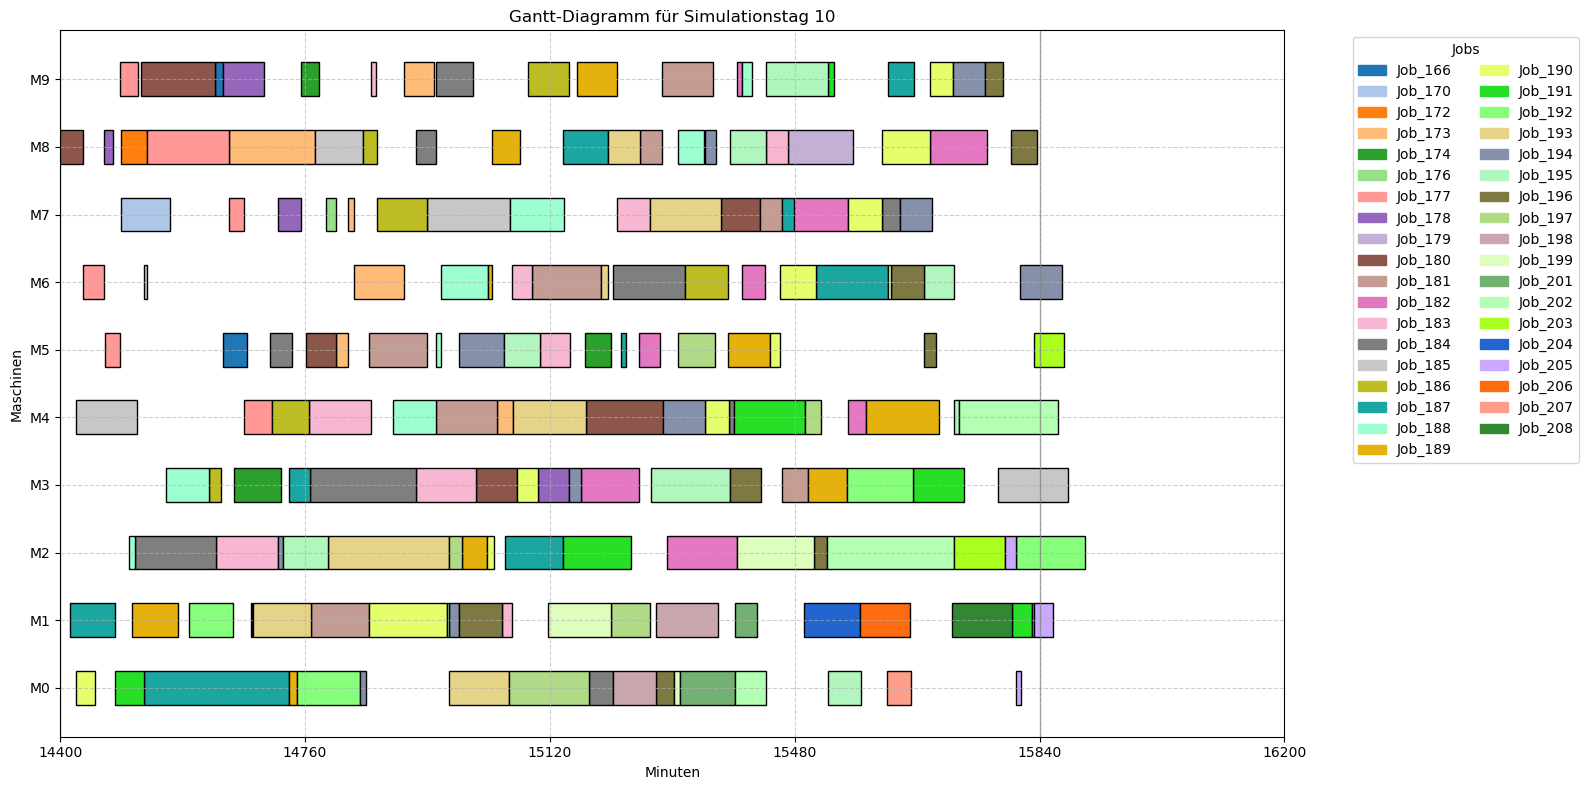

Not executed operations: 14
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 325.00
Best Objective Bound  : 325.00
Laufzeit              : 2.34 Sekunden

  Scheduling-Dauer: 0 Minuten und 2.54 Sekunden.


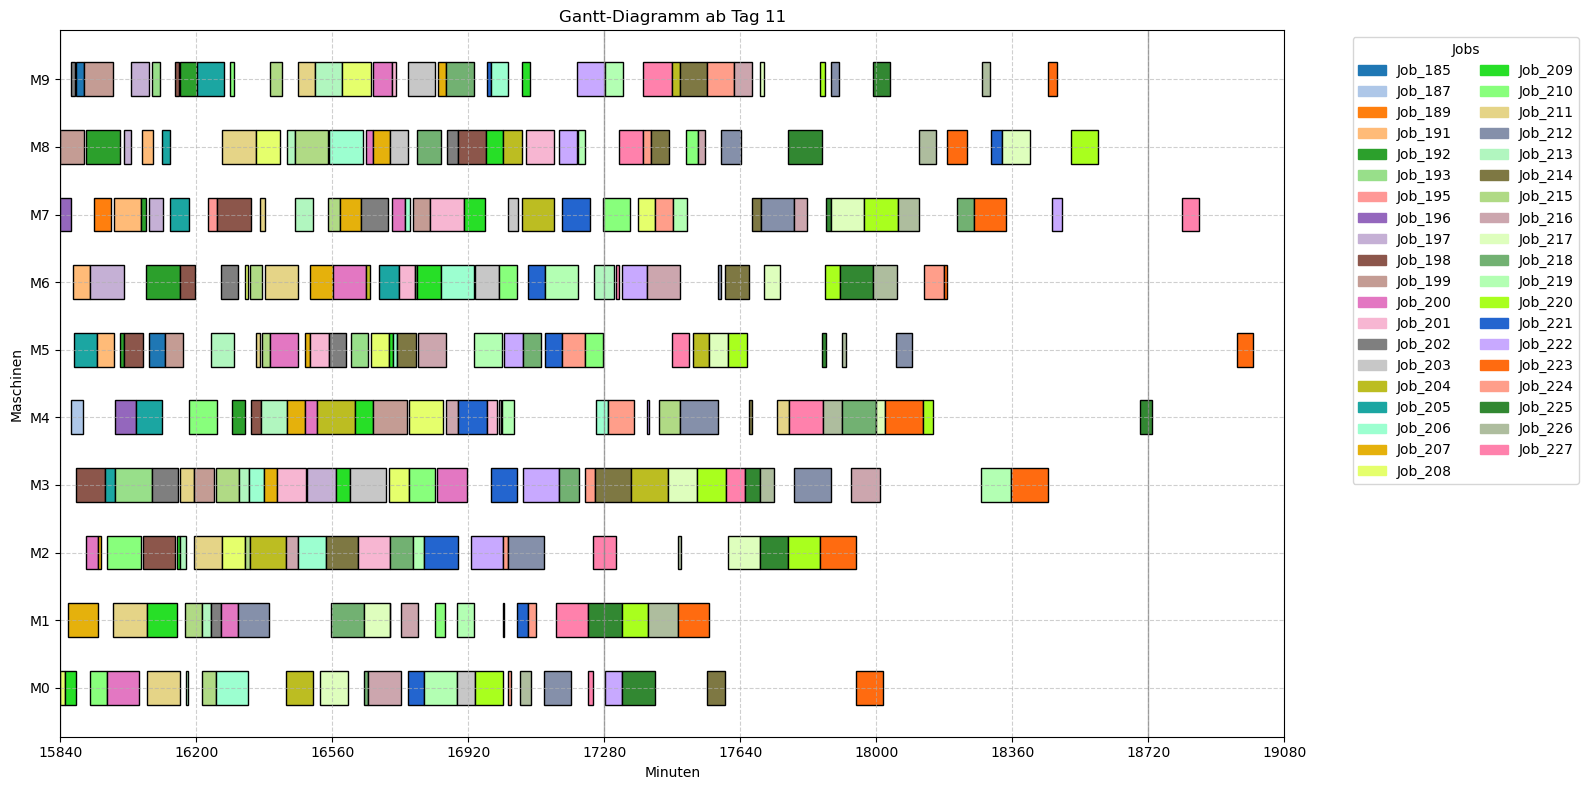

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              36
0 - 60          1
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[264:00:00] Job_196 started on M7
[264:00:00] Job_199 started on M8
[264:00:00] Job_208 started on M0
[264:10:55] Job_208 finished on M0 (after 10 minutes 55 seconds)
[264:13:00] Job_209 started on M0
[264:21:00] Job_207 started on M1
[264:28:00] Job_187 started on M4
[264:28:00] Job_202 started on M9
[264:32:34] Job_209 finished on M0 (after 19 minutes 35 seconds)
[264:34:00] Job_191 started on M6
[264:36:00] Job_205 started on M5
[264:36:05] Job_202 finished on M9 (after 08 minutes 05 seconds)
[264:42:00] Job_185 started on M9
[264:43:00] Job_198 sta

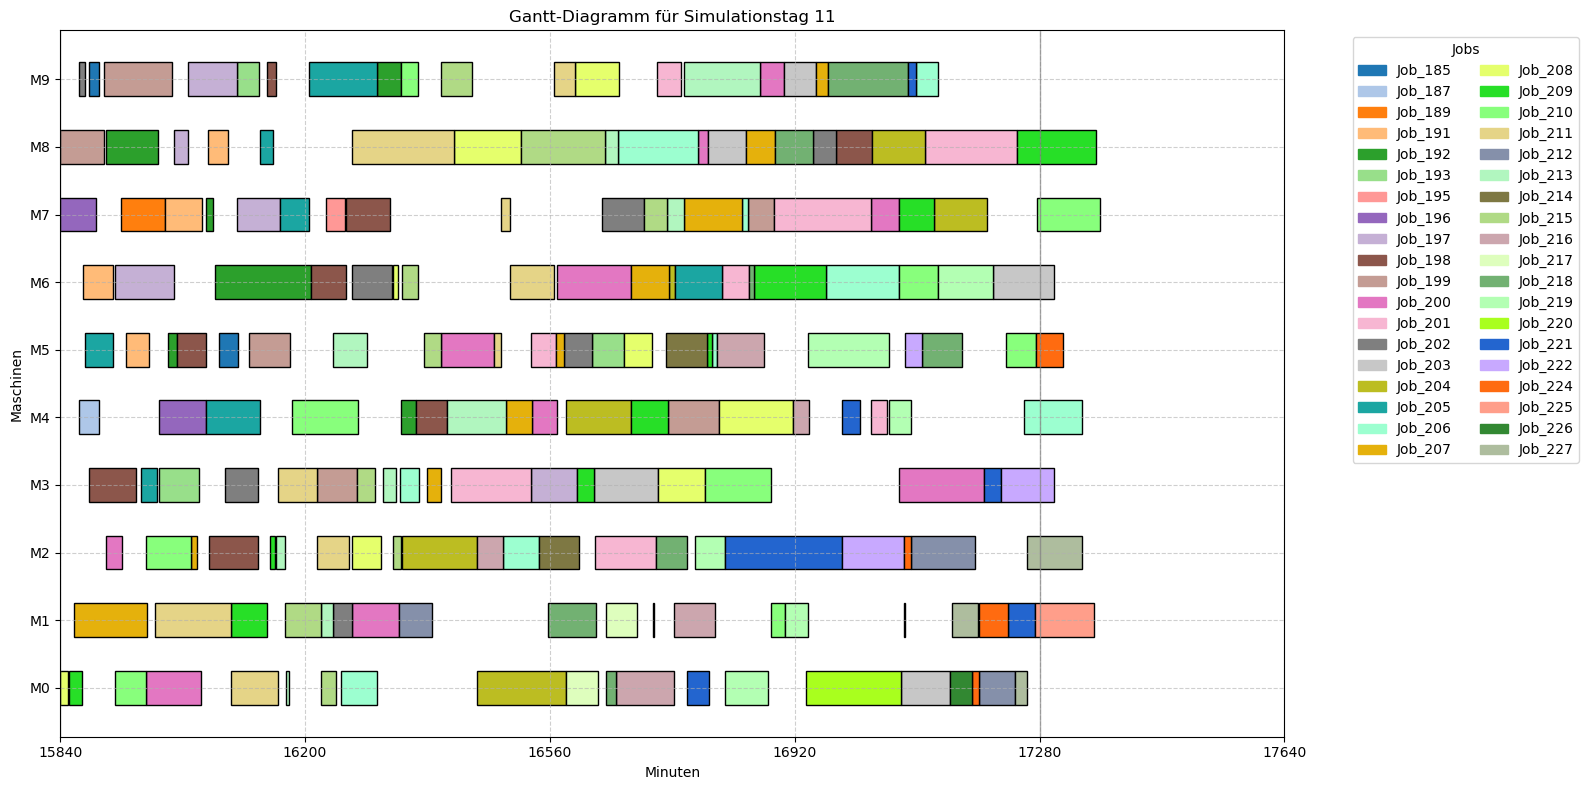

Not executed operations: 13
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 3800.00
Best Objective Bound  : 3800.00
Laufzeit              : 7.18 Sekunden

  Scheduling-Dauer: 0 Minuten und 7.37 Sekunden.


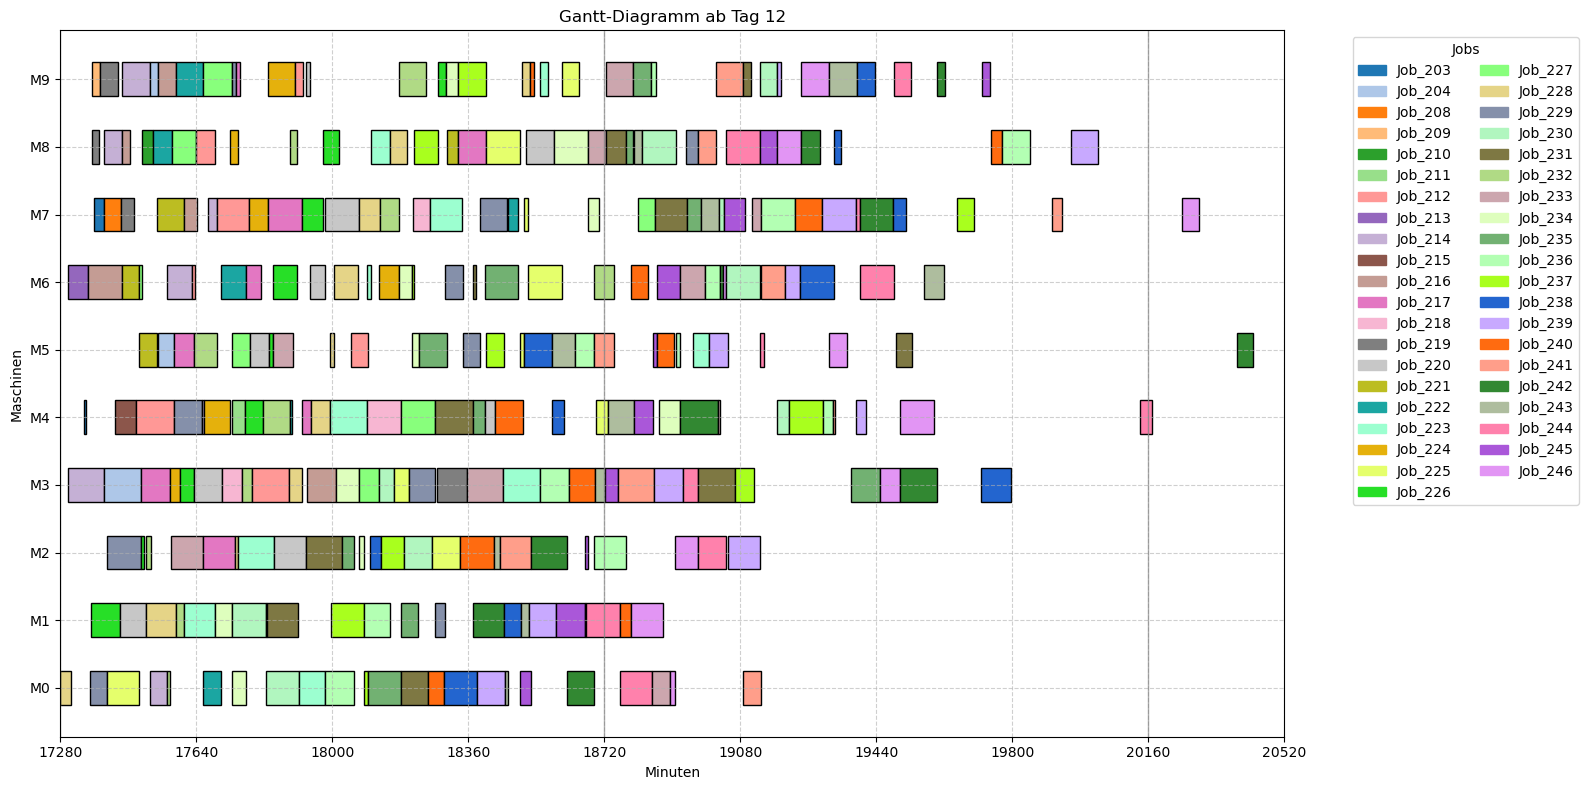

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              34
0 - 60          3
60 - 120        0
120 - 180       0
>180            2
Name: count, dtype: int32
[288:00:00] Job_228 started on M0
[288:22:00] Job_213 started on M6
[288:22:00] Job_214 started on M3
[288:41:19] Job_228 finished on M0 (after 41 minutes 20 seconds)
[289:02:00] Job_203 started on M4
[289:07:10] Job_203 finished on M4 (after 05 minutes 11 seconds)
[289:18:27] Job_213 finished on M6 (after 56 minutes 27 seconds)
[289:18:27] Job_216 started on M6
[289:20:00] Job_229 started on M0
[289:21:00] Job_226 started on M1
[289:24:00] Job_209 started on M9
[289:24:00] Job_219 started on M8
[289:30:00] Job_203 started on M7
[289:36:44] Job_209 fin

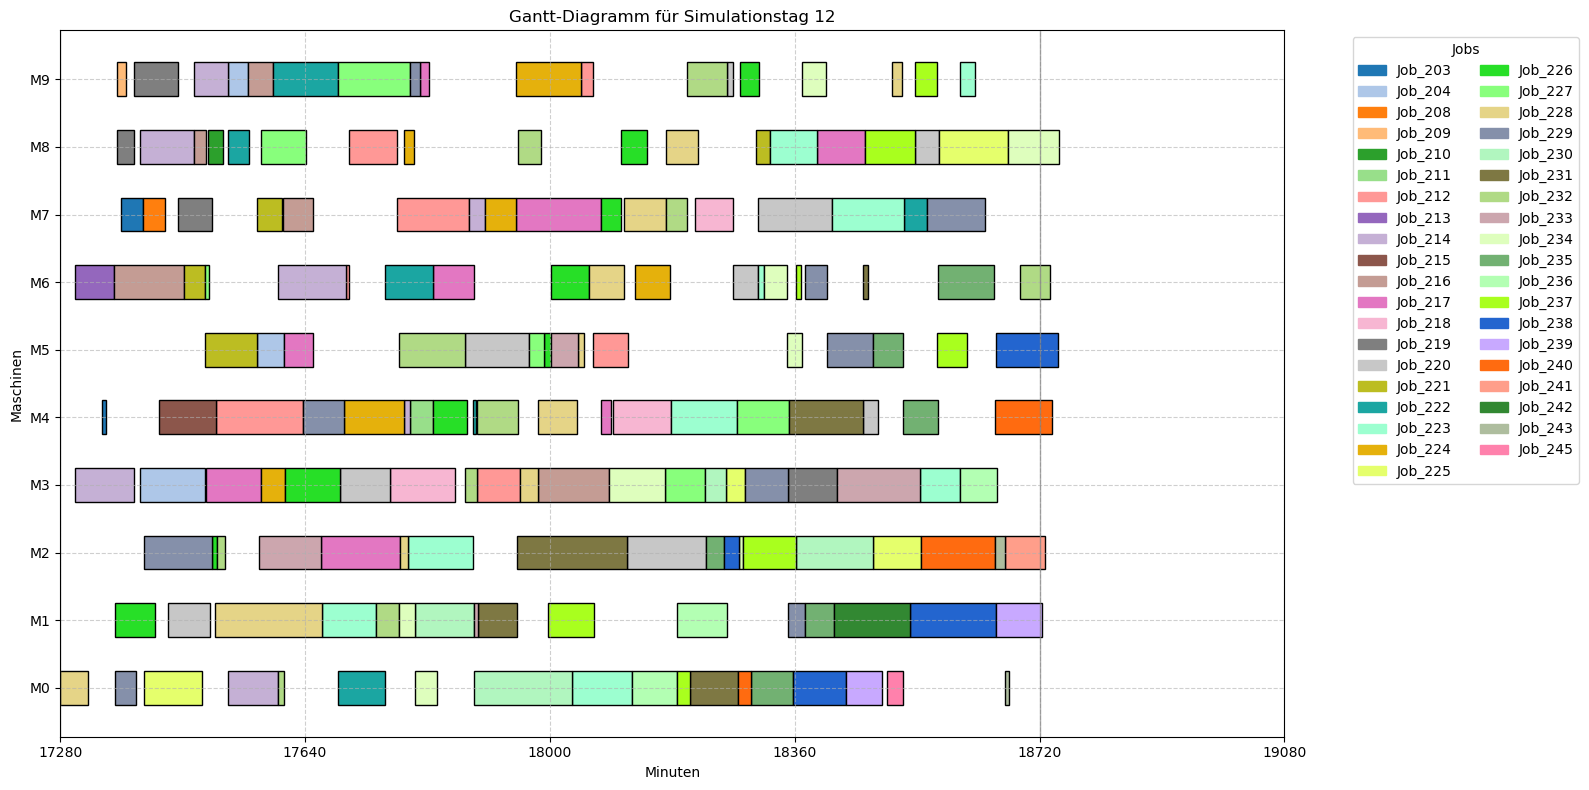

Not executed operations: 22
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 1122.00
Best Objective Bound  : 1122.00
Laufzeit              : 4.57 Sekunden

  Scheduling-Dauer: 0 Minuten und 4.95 Sekunden.


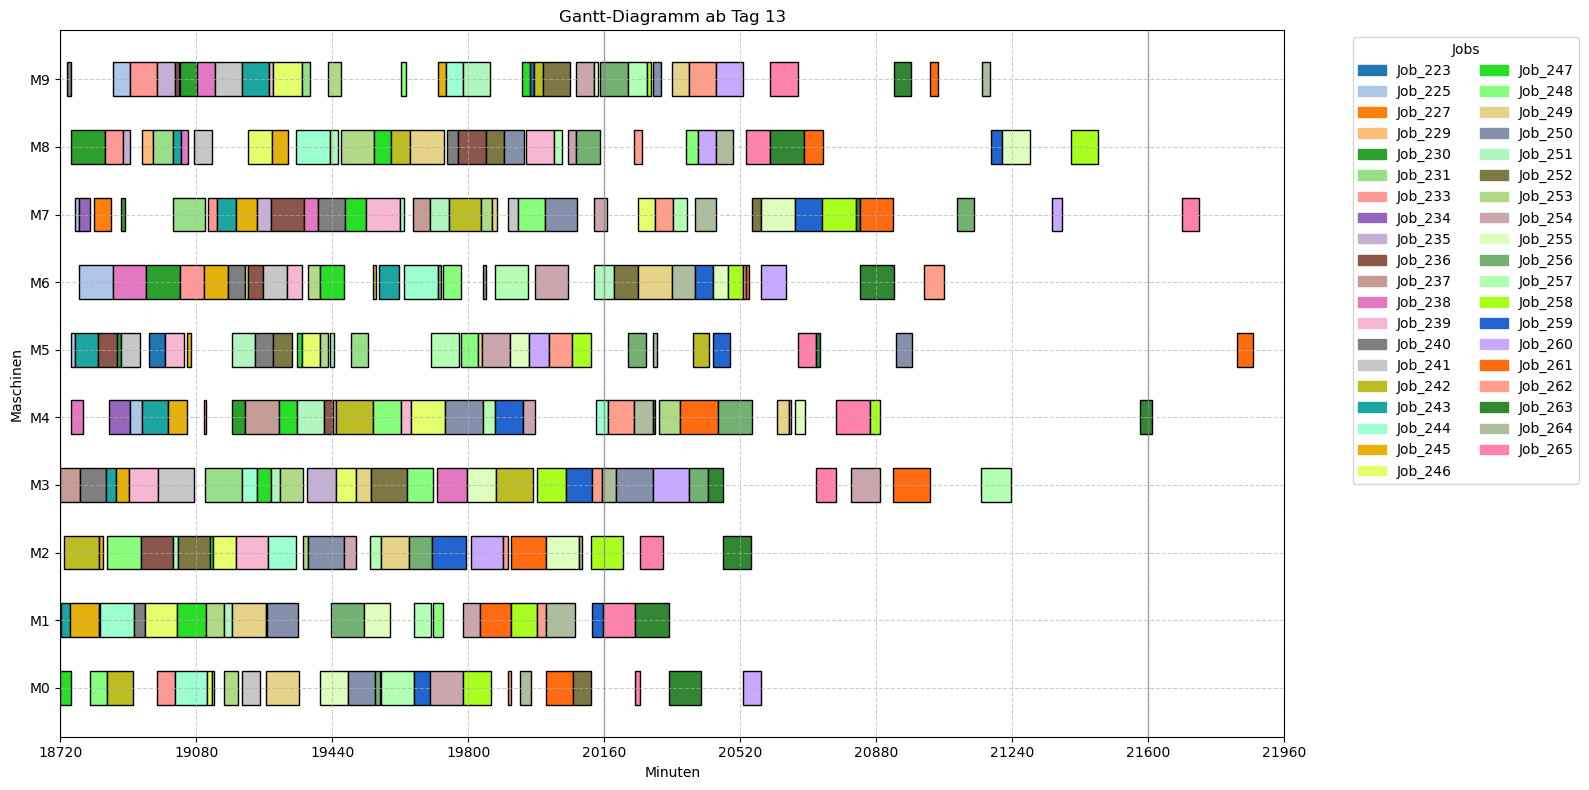

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              35
0 - 60          0
60 - 120        0
120 - 180       0
>180            1
Name: count, dtype: int32
[312:00:00] Job_237 started on M3
[312:00:00] Job_247 started on M0
[312:03:00] Job_243 started on M1
[312:09:00] Job_242 started on M2
[312:09:04] Job_247 finished on M0 (after 09 minutes 04 seconds)
[312:19:00] Job_240 started on M9
[312:23:42] Job_243 finished on M1 (after 20 minutes 43 seconds)
[312:25:00] Job_245 started on M1
[312:28:00] Job_225 started on M5
[312:28:00] Job_238 started on M4
[312:28:15] Job_240 finished on M9 (after 09 minutes 15 seconds)
[312:29:00] Job_230 started on M8
[312:36:52] Job_225 finished on M5 (after 08 minutes 52 s

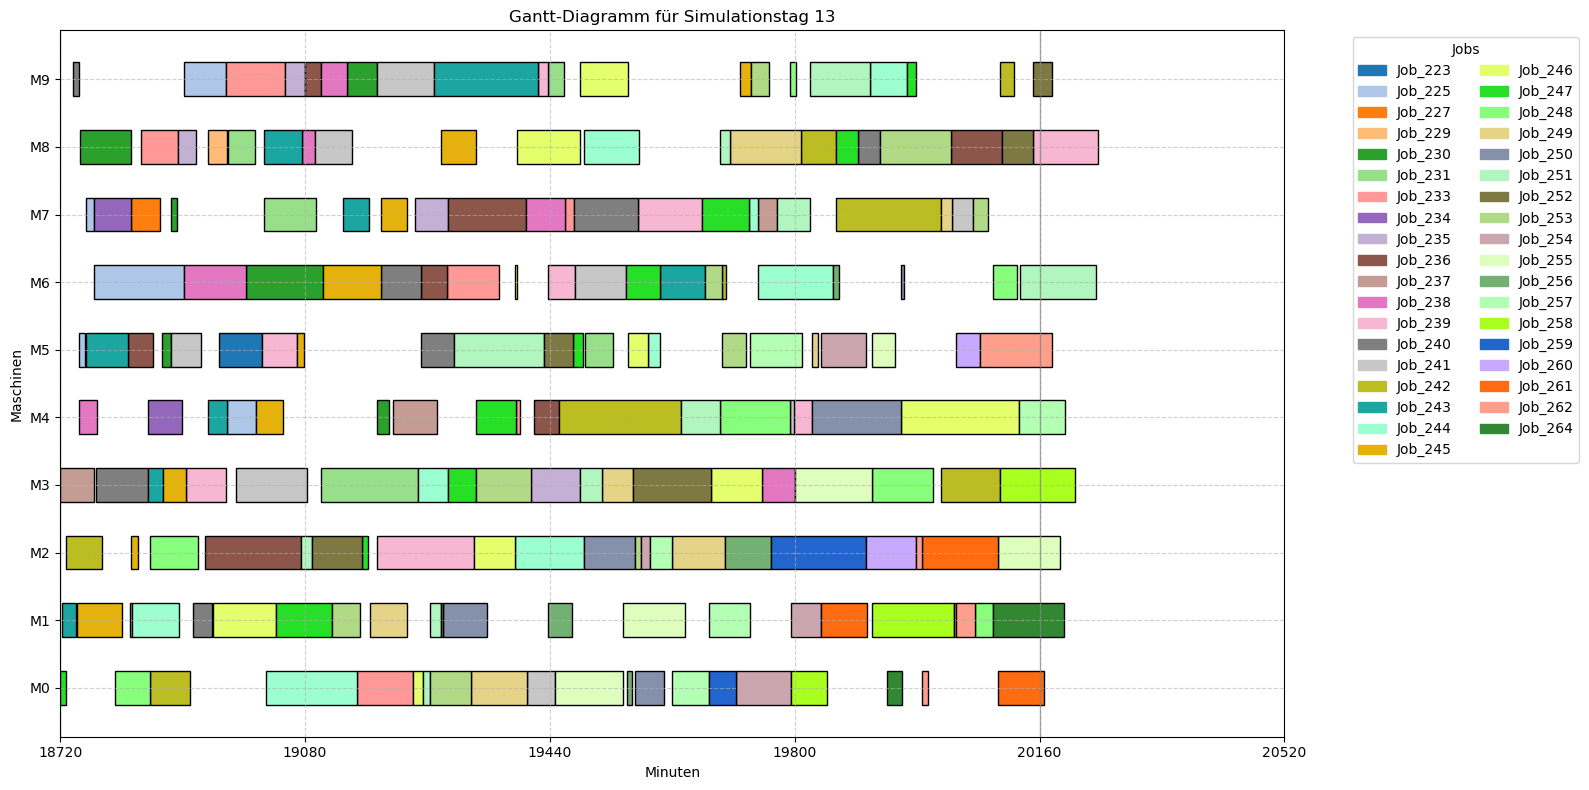

Not executed operations: 26
----------------------------------------------------------------------

Solver-Status         : OPTIMAL
Objective Value       : 375.00
Best Objective Bound  : 375.00
Laufzeit              : 5.08 Sekunden

  Scheduling-Dauer: 0 Minuten und 5.34 Sekunden.


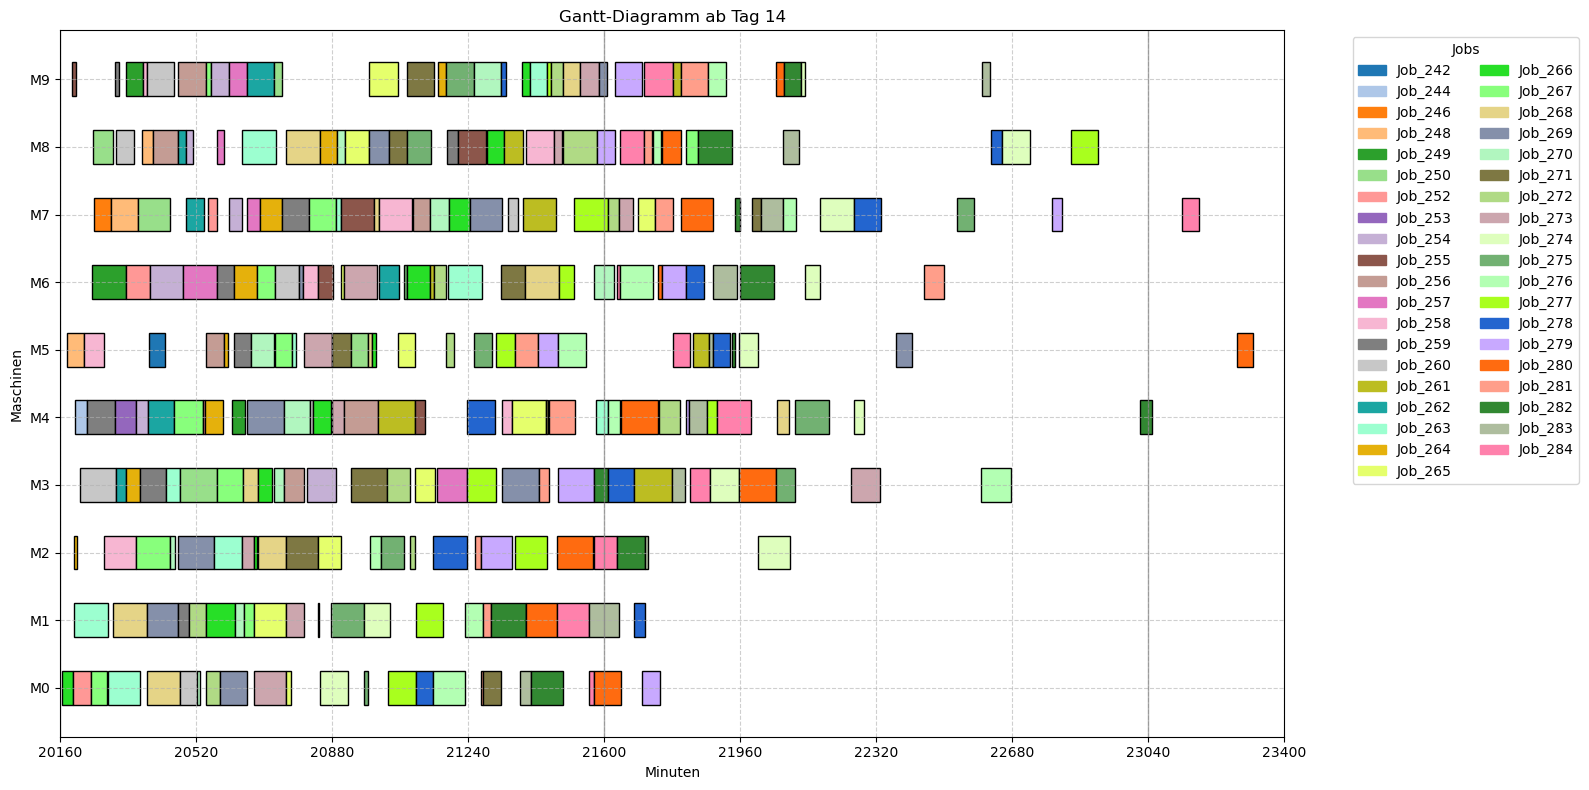

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              36
0 - 60          0
60 - 120        1
120 - 180       0
>180            0
Name: count, dtype: int32
[336:06:00] Job_266 started on M0
[336:18:00] Job_248 started on M5
[336:30:11] Job_266 finished on M0 (after 24 minutes 11 seconds)
[336:31:00] Job_255 started on M9
[336:35:00] Job_252 started on M0
[336:36:00] Job_263 started on M1
[336:36:00] Job_264 started on M2
[336:38:00] Job_244 started on M4
[336:40:47] Job_255 finished on M9 (after 09 minutes 47 seconds)
[336:41:52] Job_264 finished on M2 (after 05 minutes 52 seconds)
[336:53:00] Job_260 started on M3
[336:57:19] Job_248 finished on M5 (after 39 minutes 20 seconds)
[337:04:00] Job_258 starte

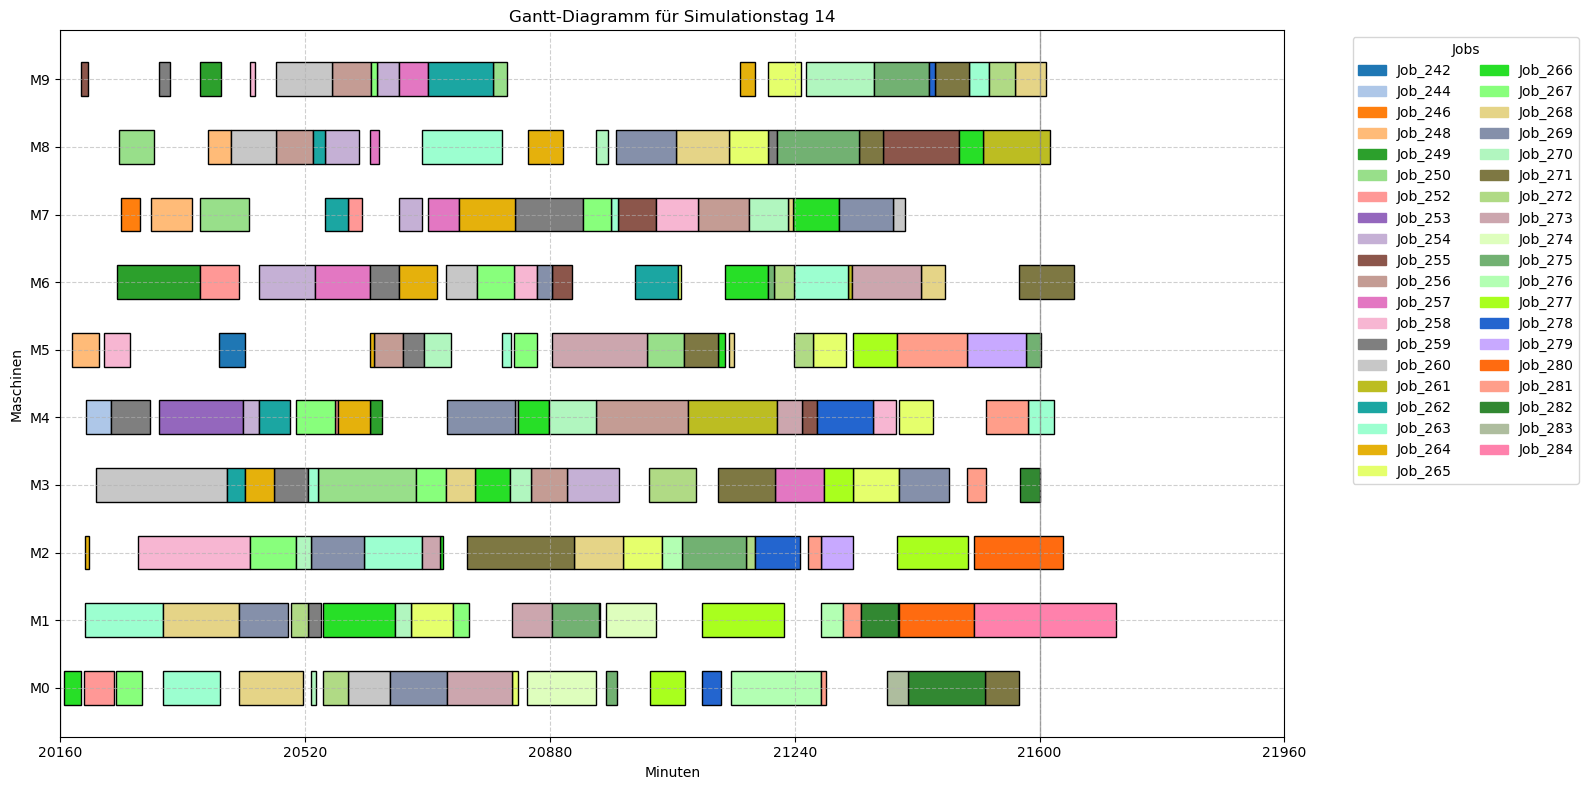

Not executed operations: 19
----------------------------------------------------------------------


In [33]:
prefix_name = "06_simple"

first_start = 1
last_planning_start = 14

df_plan = df_plan_init
df_execution = df_execution_init
df_undone = df_undone_init

for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, day_end)
    df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)

    # ------------------- IIb. Relevante unsprünglich eingeplannte Operationen ------- (uneinplant, da nicht in Sim)

    df_jssp_curr = rp_proced.extend_operations_starting_today_plus(df_jssp_curr, df_plan, day_start)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)
    
    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = rssv.solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(df_jssp_curr, df_times_curr, df_execution_important,
                                                                                    w_t = 5, reschedule_start = day_start, 
                                                                                    msg=False, timeLimit=max_time, gapRel= 0)

    
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(prefix_name, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)

    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60))

    # ------------------- IV. Einen Tag simulieren -------------------------------------
    filt = (df_plan.Start < day_end)
    df_plan_for_sim = df_plan[filt]
    
    simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.35)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")
        
    n_undone = len(df_undone)
    print(f"Not executed operations: {n_undone}")
    print("-" * 70)

## B) Rolling Planning mit "Deviation Penalty"

**Zielfunktion:**

Minimiere die gewichtete Summe aus Tardiness, Earliness und Abweichung vom ursprünglichen Startzeitpunkt (Deviation):

\\[
Z = r \cdot \sum_{j} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right) + (1 - r) \cdot \sum_{j,o} \left| S_{jo} - S_{jo}^{\text{original}} \right|
\\]

wobei:

- \\( r \in [0,\ 1] \\): Gewichtung zwischen Termintreue und Planstabilität  
- \\( w_t \in \mathbb{N},\ w_e \in \mathbb{N} \\): Gewicht für Tardiness und Earliness  
- \\( \text{Tardiness}_j = \max(0, C_j - d_j) \\), \\( \text{Earliness}_j = \max(0, d_j - C_j) \\)  
    - \\( C_j \\) ist das Fertigstellungsdatum des letzten Schritts von Job \\( j \\)  
    - \\( d_j \\) ist die Deadline für Job \\( j \\)  
- \\( S_{jo} \\) ist der Startzeitpunkt der \\( o \\)-ten Operation von Job \\( j \\)  
- \\( S_{jo}^{\text{original}} \\) ist der ursprünglich geplante Startzeitpunkt

In [36]:
from ortools.sat.python import cp_model
import pandas as pd
import math

def solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    df_executed: pd.DataFrame,
    df_original_plan: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    r: float = 0.5,
    reschedule_start: float = 1440.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    """
    Solves a Job-Shop Scheduling Problem using Constraint Programming with:
    - weighted tardiness,
    - earliness,
    - deviation penalty from a given reference plan (df_original_plan).

    Only deviations for operations present in both df_jssp and df_original_plan are considered.

    Parameters:
        df_jssp: Job-Shop structure with ['Job','Operation','Machine','Processing Time']
        df_arrivals_deadlines: Arrival and Deadline info per Job
        df_executed: Already executed operations
        df_original_plan: Reference plan with original start times
        w_t, w_e: Weights for tardiness and earliness
        r: Relative weight between lateness and deviation (0–1)
        reschedule_start: Planning starts from this time onward
        sort_ascending: Sort jobs by deadline ascending (default: False)
        msg: Verbose solver output
        timeLimit: Max solver time in seconds
        gapRel: Relative gap limit

    Returns:
        df_schedule: A DataFrame with scheduled operations and timing info
    """

    model = cp_model.CpModel()
    w_t = int(w_t)
    w_e = int(w_e)
    r_scaled = int(round(r * 100))  # scaled for integer arithmetic

    # === Vorbereitung: Ankunft, Deadline, Jobliste ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Relevante Deviation-Paare bestimmen ===
    deviation_relevant_ops = set(
        df_jssp[["Job", "Operation"]].apply(tuple, axis=1)
    ) & set(
        df_original_plan[["Job", "Operation"]].apply(tuple, axis=1)
    )

    original_start = {
        (row["Job"], row["Operation"]): int(round(row["Start"]))
        for _, row in df_original_plan.iterrows()
        if (row["Job"], row["Operation"]) in deviation_relevant_ops
    }

    # === Operationen strukturieren ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Planungshorizont abschätzen ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Fixierte Operationen berücksichtigen ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }
    last_executed_end = df_executed.groupby("Job")["End"].max().to_dict()

    # === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []
    deviation_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Constraints und Zielterme ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = End - Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Startzeitbedingungen
        model.Add(starts[(j, 0)] >= max(arrival[job], int(reschedule_start)))
        if job in last_executed_end:
            model.Add(starts[(j, 0)] >= int(math.ceil(last_executed_end[job])))

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

        # Deviation: nur für relevante Ops
        for o, (op_id, _, _) in enumerate(all_ops[j]):
            key = (job, op_id)
            if key in original_start:
                dev = model.NewIntVar(0, horizon, f"dev_{j}_{o}")
                diff = model.NewIntVar(-horizon, horizon, f"diff_{j}_{o}")
                model.Add(diff == starts[(j, o)] - original_start[key])
                model.AddAbsEquality(dev, diff)
                deviation_terms.append(dev)

    # === Maschinenrestriktionen (inkl. fixierter Intervalle) ===
    for m in machines:
        machine_intervals = [interval for (j, o), (interval, mach) in intervals.items() if mach == m]
        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            duration = end - start
            if duration > 0:
                fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
                machine_intervals.append(fixed_interval)
        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion kombinieren ===
    weighted_part = model.NewIntVar(0, horizon * len(weighted_terms), "weighted_part")
    deviation_part = model.NewIntVar(0, horizon * len(deviation_terms), "deviation_part")
    model.Add(weighted_part == sum(weighted_terms))
    model.Add(deviation_part == sum(deviation_terms))

    total_cost = model.NewIntVar(0, horizon * len(jobs) * 100, "total_cost")
    model.Add(total_cost == r_scaled * weighted_part + (100 - r_scaled) * deviation_part)
    model.Minimize(total_cost)

    # === Solver-Einstellungen ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.max_time_in_seconds = timeLimit
    solver.parameters.relative_gap_limit = gapRel
    status = solver.Solve(model)

    # === Ergebnis extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")
    print(f"Deviation terms       : {len(deviation_terms)}")

    return df_schedule



Solver-Status         : OPTIMAL
Objective Value       : 104650.00
Best Objective Bound  : 99430.00
Laufzeit              : 500.46 Sekunden
Deviation terms       : 78

  Scheduling-Dauer: 8 Minuten und 20.71 Sekunden.


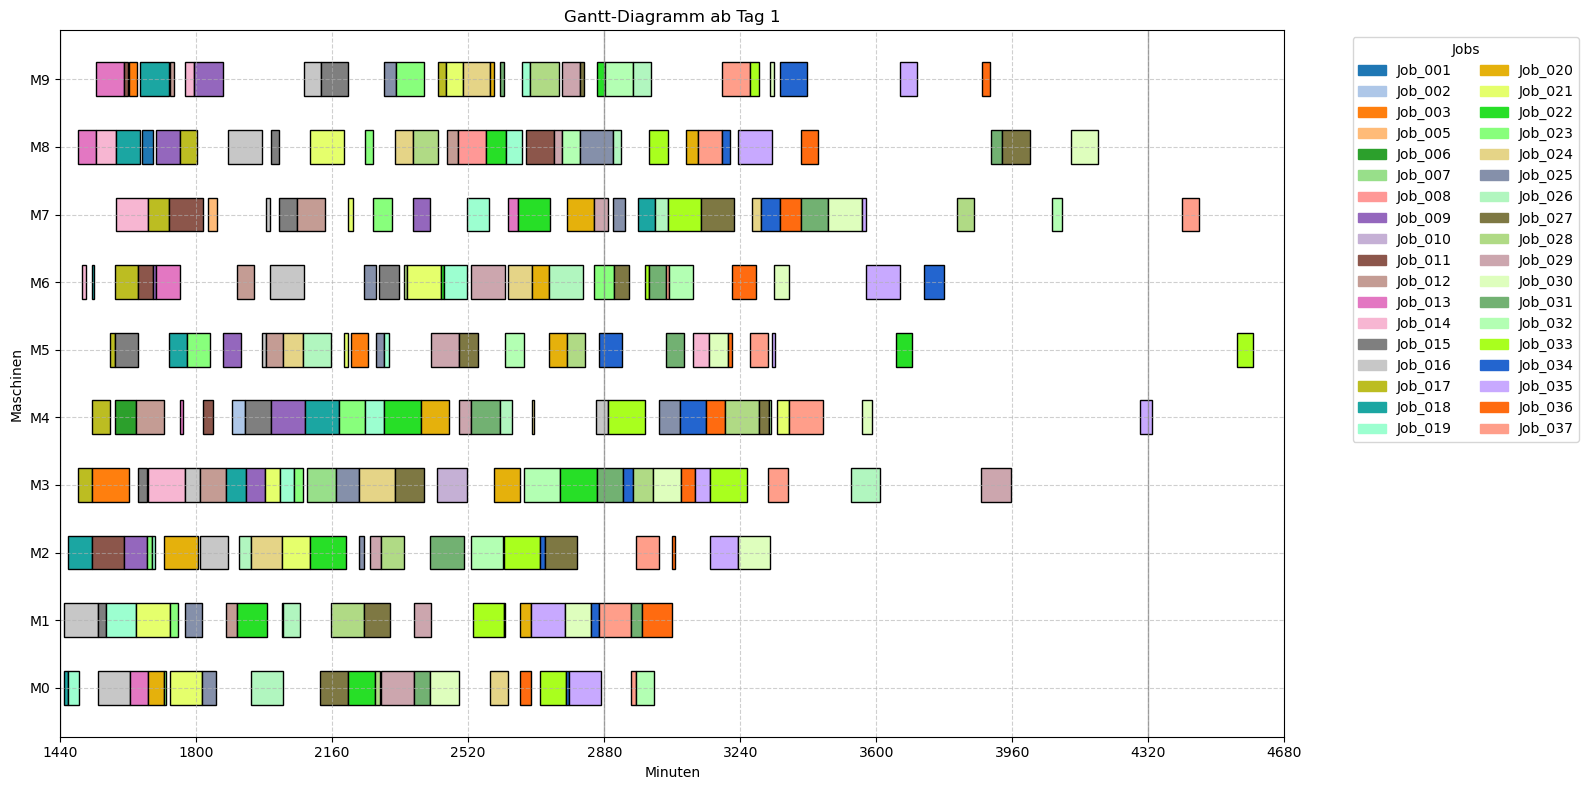

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              34
0 - 60          0
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[24:09:00] Job_016 started on M1
[24:09:00] Job_018 started on M0
[24:13:32] Job_018 finished on M0 (after 04 minutes 33 seconds)
[24:22:00] Job_019 started on M0
[24:22:00] Job_018 started on M2
[24:48:00] Job_013 started on M8
[24:48:00] Job_017 started on M3
[24:59:00] Job_014 started on M6
[25:05:27] Job_014 finished on M6 (after 06 minutes 28 seconds)
[25:18:39] Job_019 finished on M0 (after 56 minutes 39 seconds)
[25:20:49] Job_017 finished on M3 (after 32 minutes 50 seconds)
[25:24:00] Job_003 started on M3
[25:24:00] Job_017 started on M4
[25:3

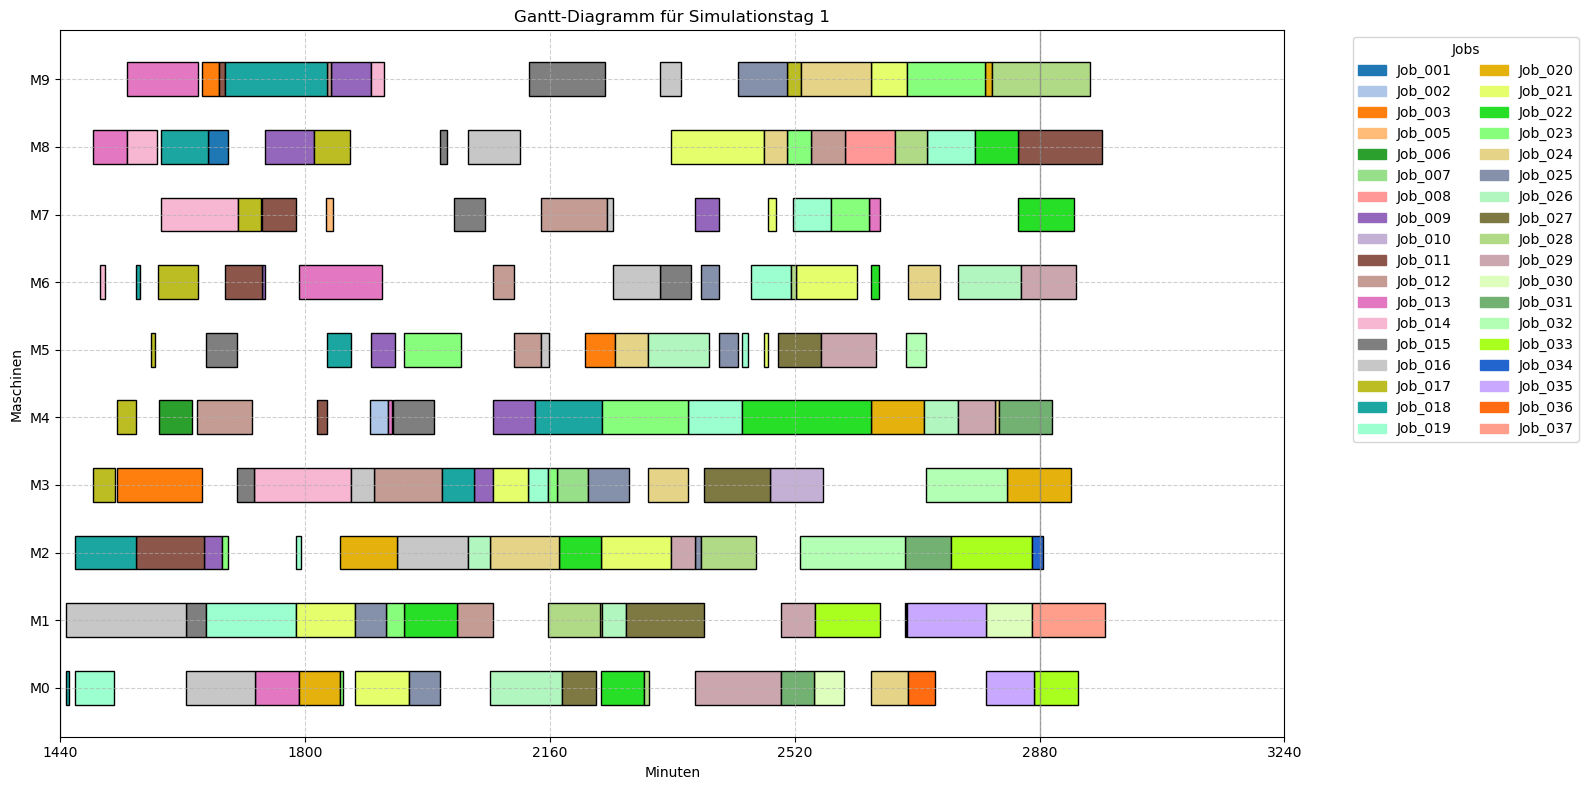

Not executed operations: 22
----------------------------------------------------------------------

Solver-Status         : FEASIBLE
Objective Value       : 573120.00
Best Objective Bound  : 508520.00
Laufzeit              : 3623.79 Sekunden
Deviation terms       : 99

  Scheduling-Dauer: 60 Minuten und 24.08 Sekunden.


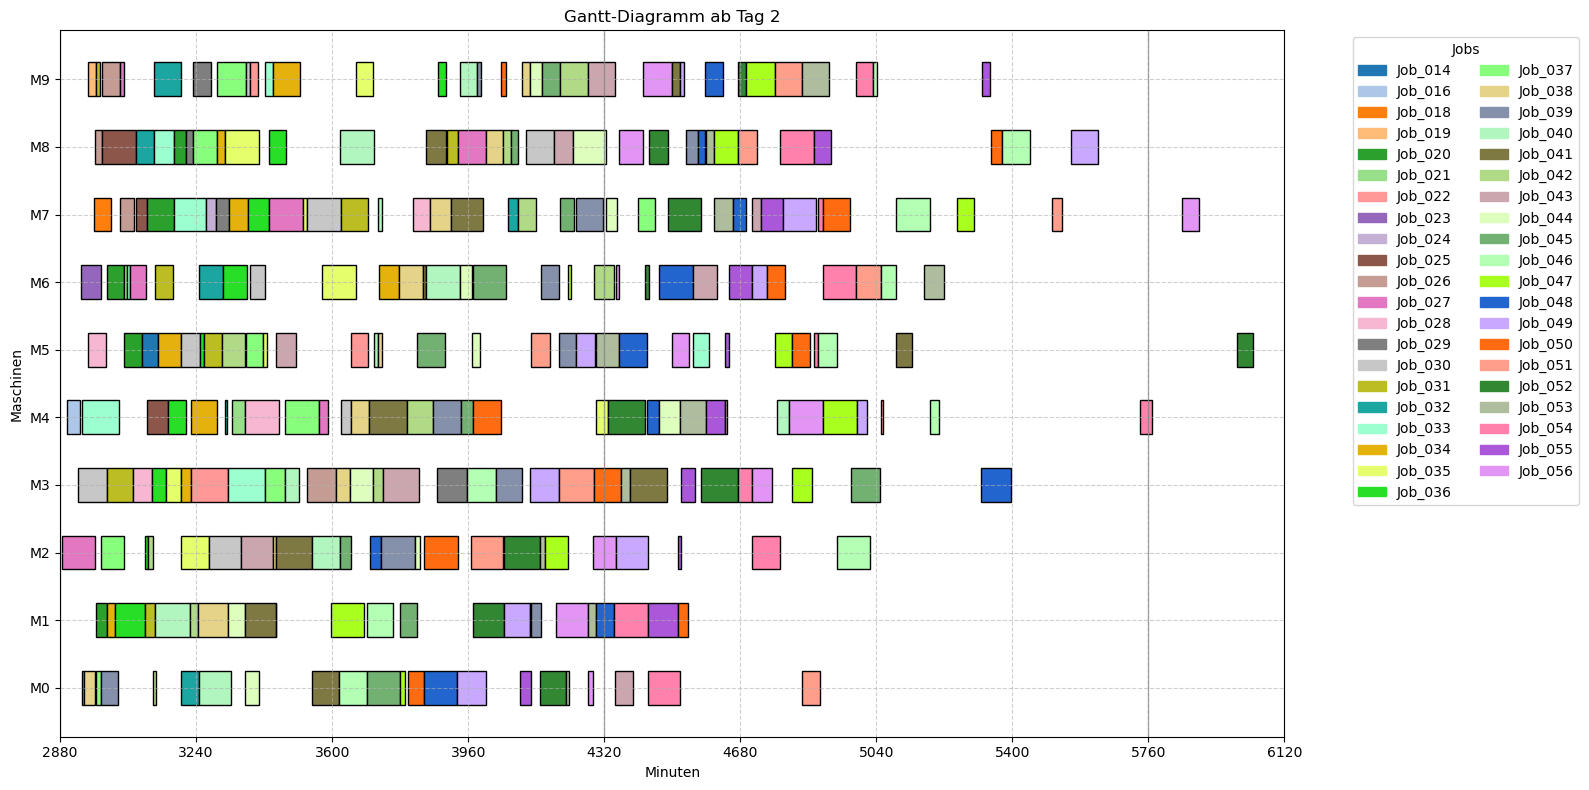

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              32
0 - 60          1
60 - 120        3
120 - 180       0
>180            1
Name: count, dtype: int32
[48:06:00] Job_027 started on M2
[48:19:00] Job_016 started on M4
[48:43:23] Job_016 finished on M4 (after 24 minutes 23 seconds)
[48:47:00] Job_030 started on M3
[48:54:00] Job_023 started on M6
[48:57:00] Job_033 started on M4
[48:57:00] Job_034 started on M0
[49:00:24] Job_027 finished on M2 (after 54 minutes 25 seconds)
[49:01:13] Job_034 finished on M0 (after 04 minutes 14 seconds)
[49:03:00] Job_038 started on M0
[49:14:00] Job_019 started on M9
[49:14:00] Job_028 started on M5
[49:26:50] Job_038 finished on M0 (after 23 minutes 51 seconds)
[49:2

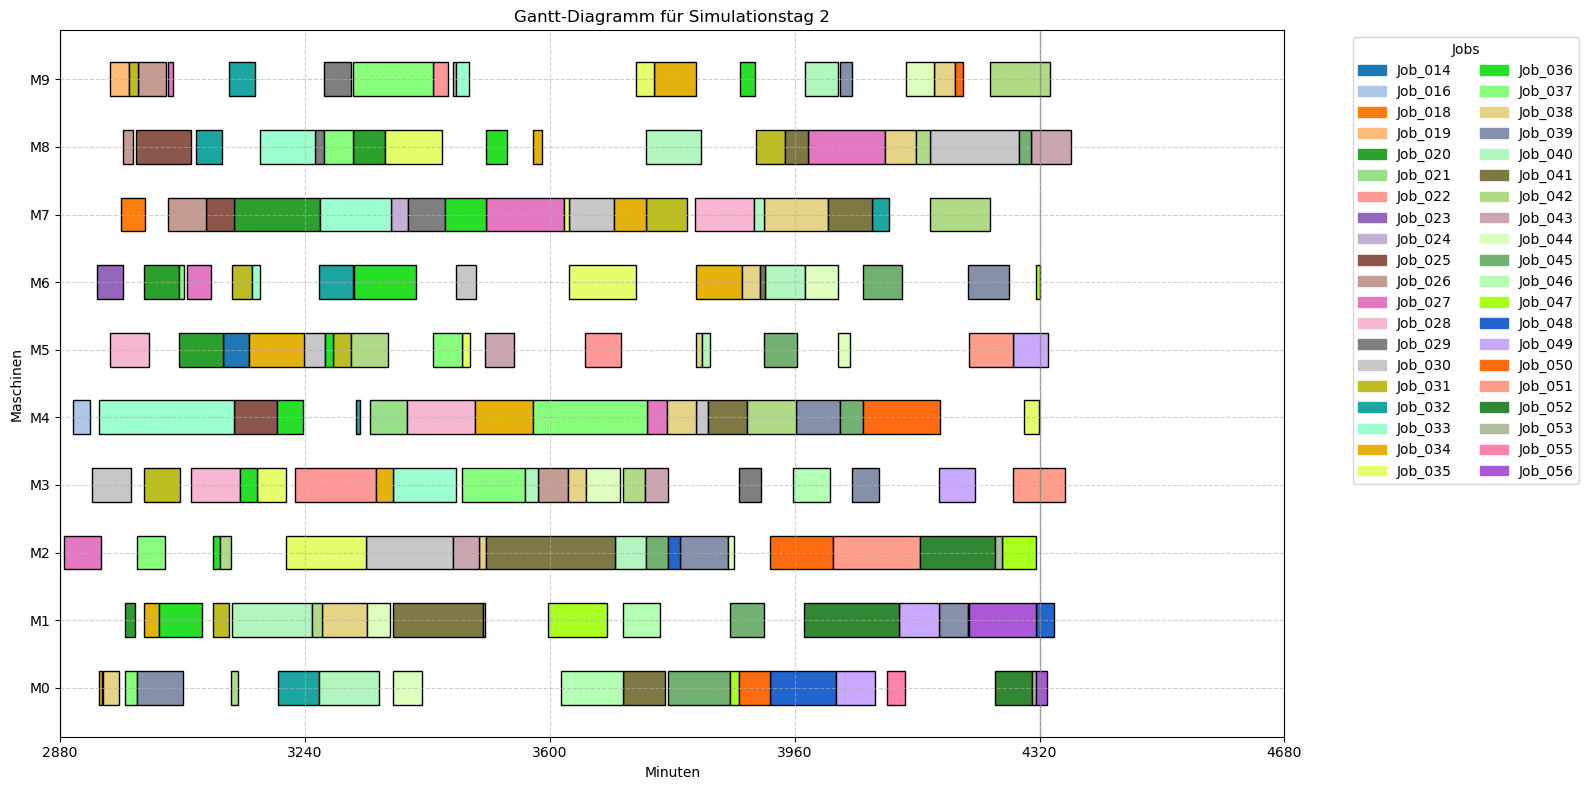

Not executed operations: 11
----------------------------------------------------------------------

Solver-Status         : FEASIBLE
Objective Value       : 156830.00
Best Objective Bound  : 136530.00
Laufzeit              : 3623.46 Sekunden
Deviation terms       : 101

  Scheduling-Dauer: 60 Minuten und 23.77 Sekunden.


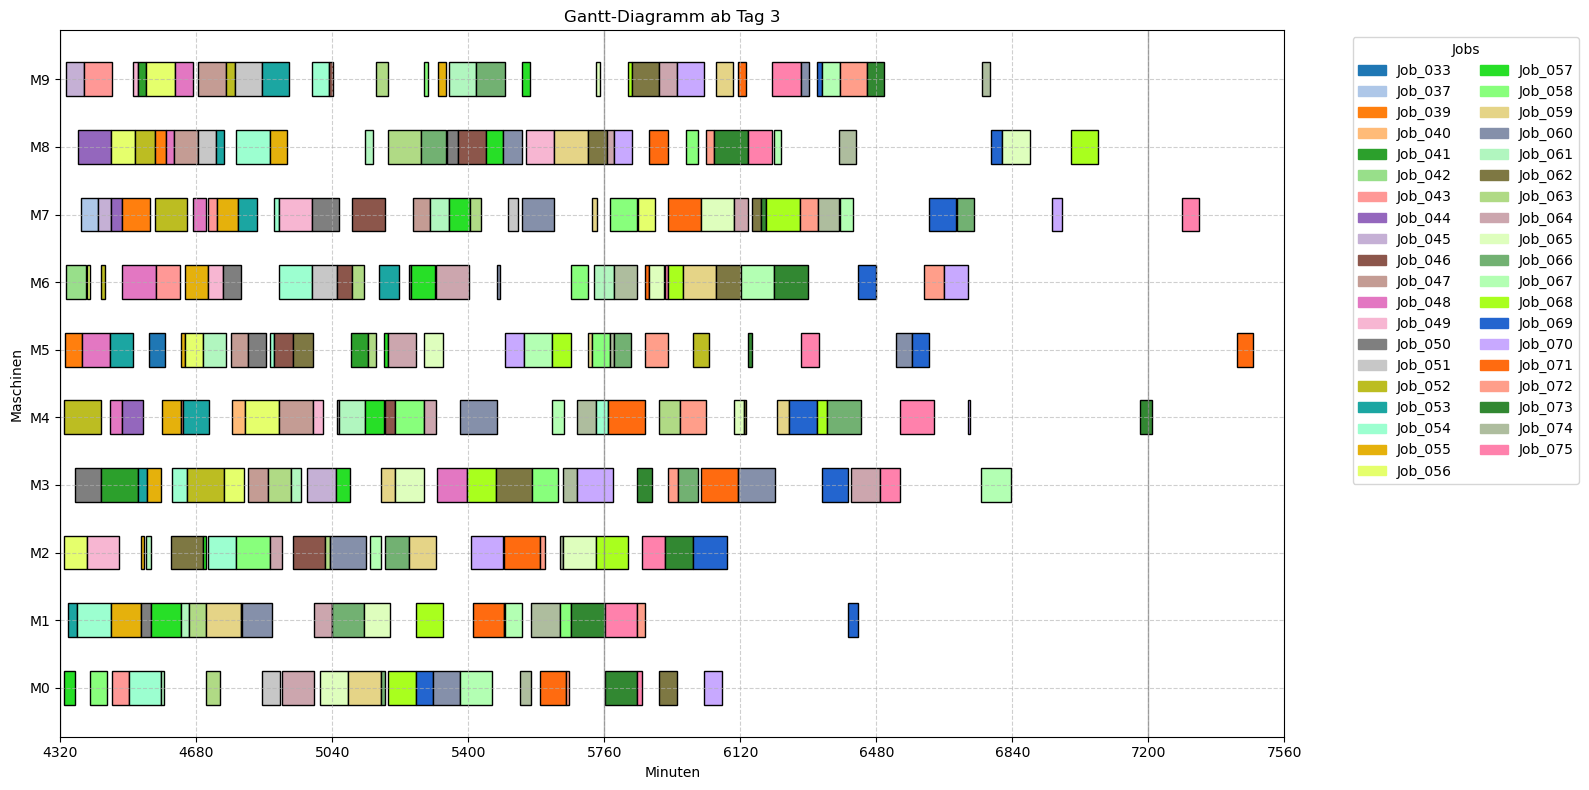

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              33
0 - 60          3
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[72:10:00] Job_052 started on M4
[72:11:00] Job_056 started on M2
[72:11:00] Job_057 started on M0
[72:13:00] Job_039 started on M5
[72:16:00] Job_042 started on M6
[72:16:00] Job_045 started on M9
[72:22:00] Job_053 started on M1
[72:38:00] Job_050 started on M3
[72:46:00] Job_044 started on M8
[72:46:56] Job_053 finished on M1 (after 24 minutes 57 seconds)
[72:46:56] Job_054 started on M1
[72:49:24] Job_039 finished on M5 (after 36 minutes 25 seconds)
[72:51:08] Job_057 finished on M0 (after 40 minutes 08 seconds)
[72:54:00] Job_037 started on M7
[72

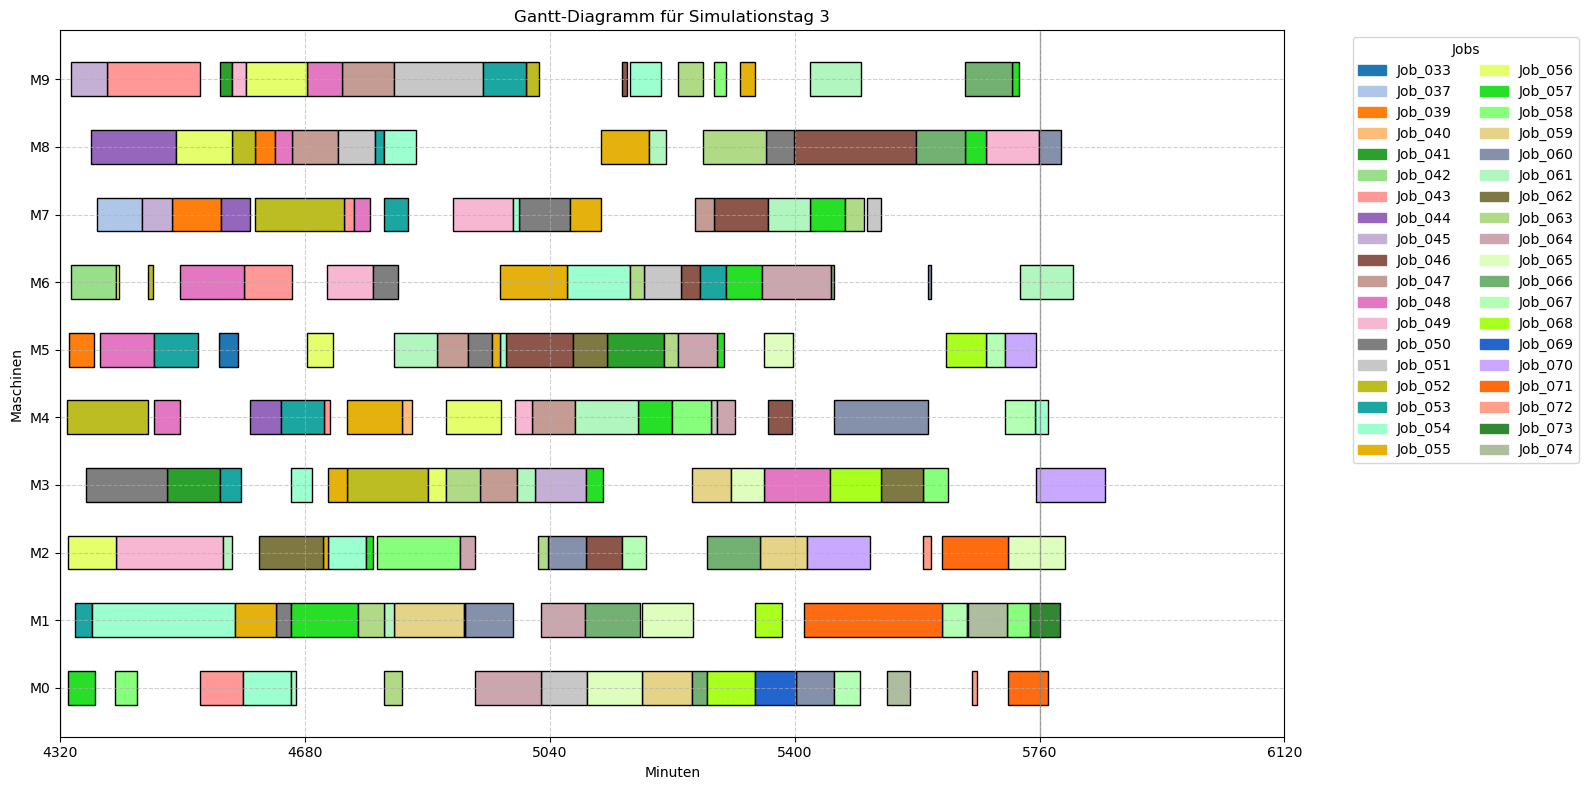

Not executed operations: 12
----------------------------------------------------------------------

Solver-Status         : FEASIBLE
Objective Value       : 190830.00
Best Objective Bound  : 160540.00
Laufzeit              : 3621.31 Sekunden
Deviation terms       : 104

  Scheduling-Dauer: 60 Minuten und 21.61 Sekunden.


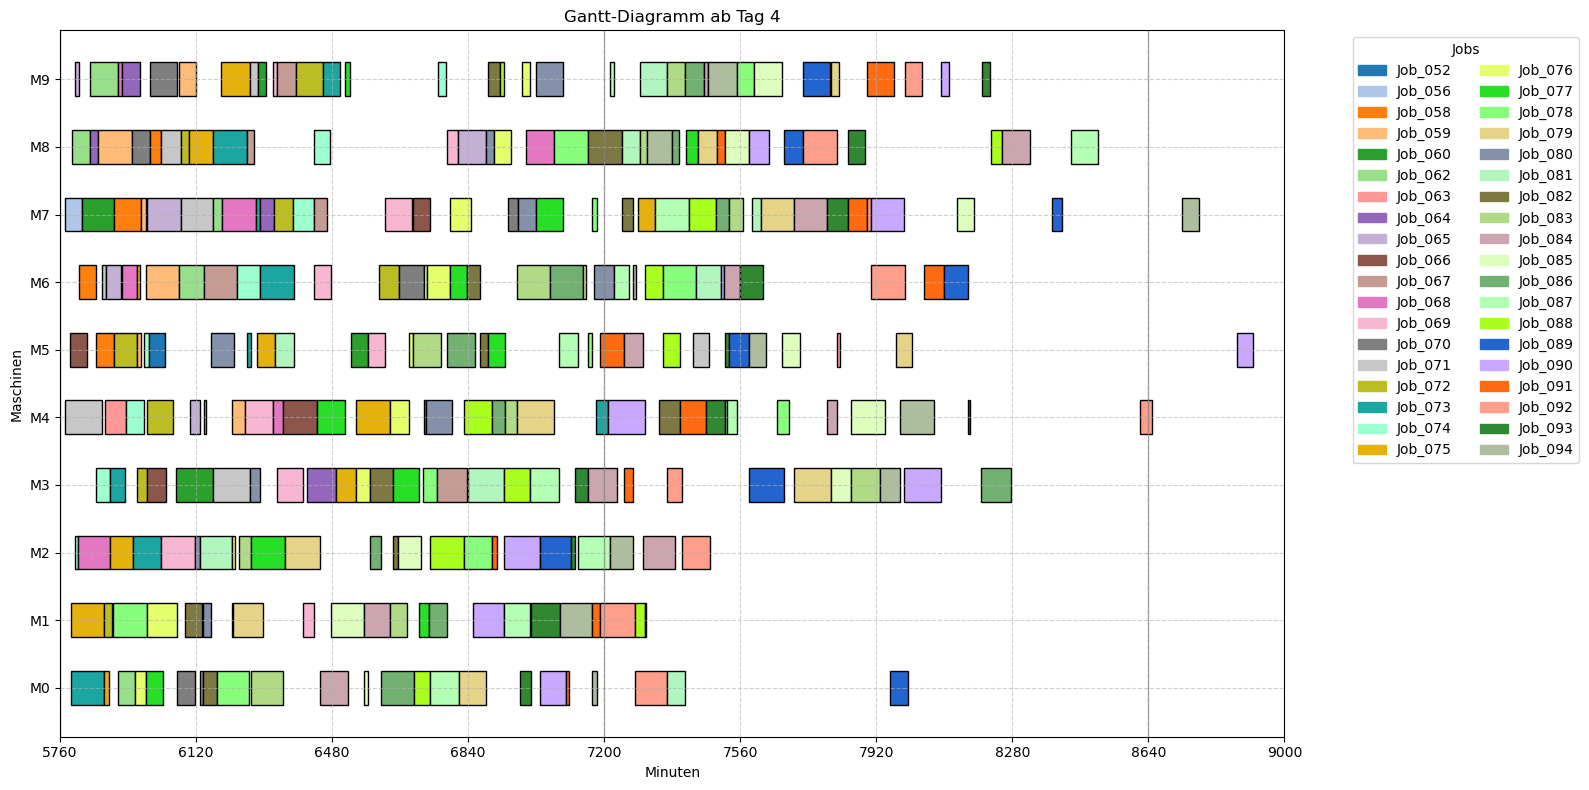

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-180           0
-180 - -120     0
-120 - -60      1
-60 - 0         3
0              32
0 - 60          2
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int32
[96:12:00] Job_056 started on M7
[96:13:00] Job_071 started on M4
[96:25:00] Job_066 started on M5
[96:30:00] Job_073 started on M0
[96:30:00] Job_075 started on M1
[96:32:00] Job_062 started on M8
[96:38:00] Job_065 started on M9
[96:38:00] Job_074 started on M2
[96:43:25] Job_074 finished on M2 (after 05 minutes 26 seconds)
[96:47:00] Job_068 started on M2
[96:47:36] Job_056 finished on M7 (after 35 minutes 37 seconds)
[96:49:25] Job_065 finished on M9 (after 11 minutes 26 seconds)
[96:50:00] Job_058 started on M6
[96:56:07] Job_066 finished on M5 (a

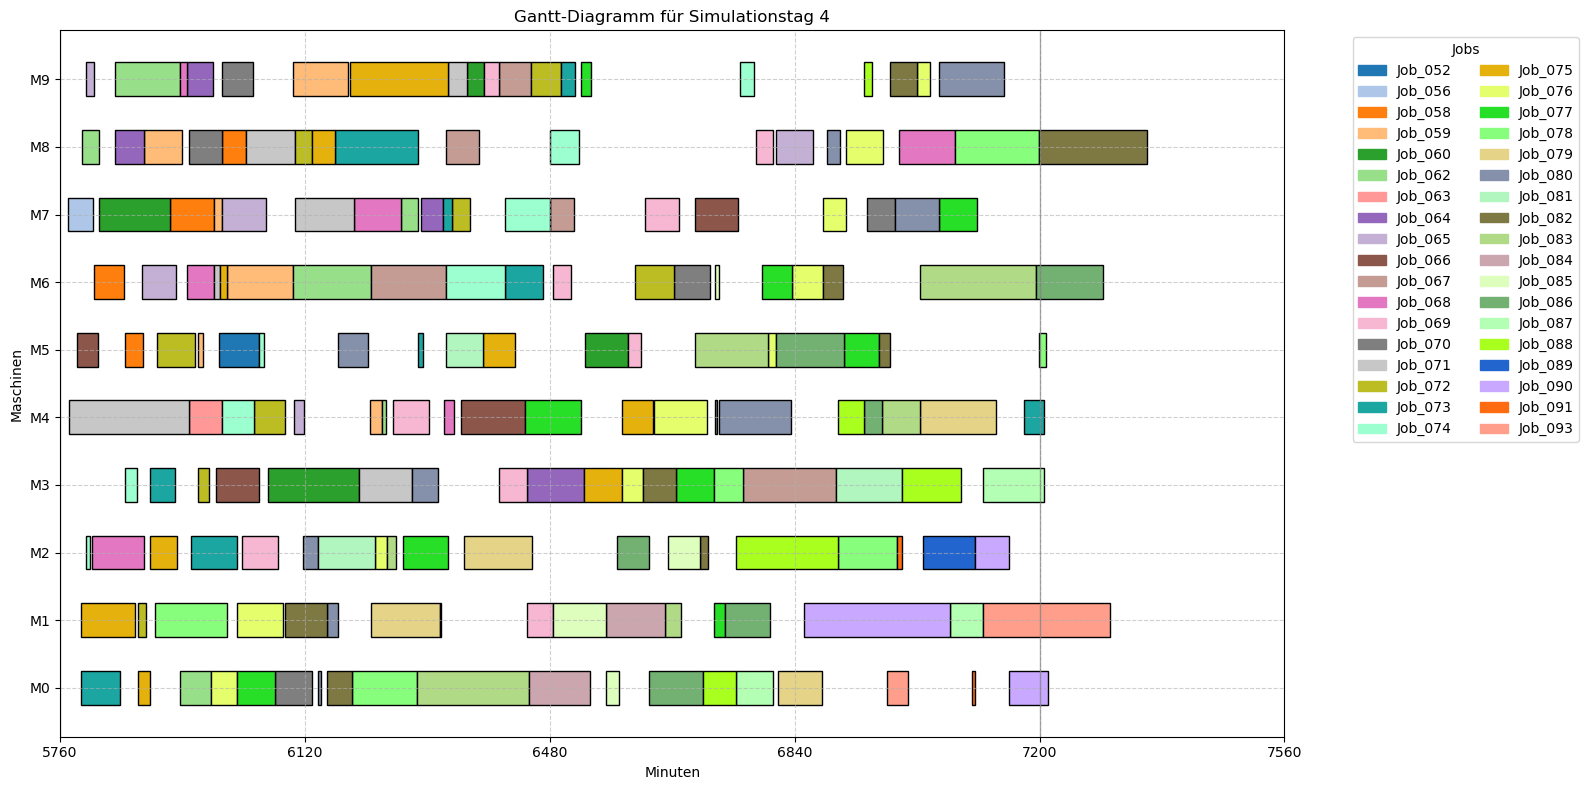

Not executed operations: 13
----------------------------------------------------------------------


In [ ]:
prefix_name = "06_devpen"
first_start = 1
last_planning_start = 14

df_plan = df_plan_init

df_execution = df_execution_init
df_undone = df_undone_init


for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, day_end)
    df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- IIa. Relevante laufende Operationen -------------------------
    df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)

    # ------------------- IIb. Relevante unsprünglich eingeplannte Operationen -------- (uneingeplant, da nicht in Sim)

    # df_plan_prev_important = rp_proced.get_operations_starting_today_plus(df_plan, day_start) # es fehlen noch die unerledigten
    df_plan_prev_important = df_plan # Devpen

    df_jssp_curr = rp_proced.extend_operations_starting_today_plus(df_jssp_curr, df_plan, day_start)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)
    
    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(df_jssp_curr, df_times_curr, df_execution_important,
                                                                                 df_original_plan = df_plan_prev_important, # prev. Plan
                                                                                 w_t = 5,
                                                                                 r = 0.70, # 70% Lateness, 30% Deviation
                                                                                 reschedule_start = day_start,
                                                                                 msg=False, timeLimit=max_time, gapRel= 0.05)

    
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(prefix_name, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)

    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60))

    # ------------------- IV. Einen Tag simulieren -------------------------------------
    filt = (df_plan.Start < day_end)
    df_plan_for_sim = df_plan[filt]
    
    simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.35)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")

    n_undone = len(df_undone)
    print(f"Not executed operations: {n_undone}")
    print("-" * 70)

In [ ]:
notebook_duration = time.time() - start_notebook
print(f"Dauer: {int(notebook_duration // 60)} Minuten und {(notebook_duration % 60):.2f} Sekunden.")